In [1]:
import os
import numpy as np


img_path = "/home/stud1/Kusum/inverseloss/images"
seg_path = "/home/stud1/Kusum/inverseloss/masks"

img_list = os.listdir(img_path)
seg_list = os.listdir(seg_path)

print(len(img_list))
print(len(seg_list))

1000
1000


In [2]:
import glob

train_img = sorted(glob.glob(os.path.join(img_path, "*.jpg")))
print(len(train_img))
train_mask = sorted(glob.glob(os.path.join(seg_path, "*.jpg")))
print(len(train_mask))
dictionary = [{"img":image_name, "seg": mask_name } for image_name, mask_name in zip(train_img, train_mask)]

1000
1000


In [3]:
from monai.utils import set_determinism
from monai.transforms import AsDiscrete
# from networks.UXNet_3D.network_backbone import UXNET
from monai.networks.nets import UNETR, SwinUNETR
# from networks.nnFormer.nnFormer_seg import nnFormer
# from networks.TransBTS.TransBTS_downsample8x_skipconnection import TransBTS
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, decollate_batch

import torch
from torch.utils.tensorboard import SummaryWriter
# from load_datasets_transforms import data_loader, data_transforms

import os
import numpy as np
from tqdm import tqdm
import argparse
from monai.config import print_config
print_config()

MONAI version: 0.9.0
Numpy version: 1.25.2
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: /home/stud1/anaconda3/envs/kusum/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
Nibabel version: 5.1.0
scikit-image version: 0.21.0
Pillow version: 10.0.0
Tensorboard version: 2.14.0
gdown version: 4.7.1
TorchVision version: 0.15.2+cu117
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.1.0
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.7.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscreted,
    Compose,
    CropForegroundd,
    SpatialPadd,
    ResizeWithPadOrCropd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    KeepLargestConnectedComponentd,
    Spacingd,
    ToTensord,
    RandAffined,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandRotate90d,
    EnsureTyped,
    Invertd,
    KeepLargestConnectedComponentd,
    SaveImaged,
    Activationsd,
    ScaleIntensityd,
    Resized,
    RandGaussianNoised,
    NormalizeIntensityd
    
)

train_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
        Resized(keys=["img", "seg"], spatial_size=[224, 224]),
        # RandCropByPosNegLabeld(
        #     keys=["img", "seg"], label_key="seg", spatial_size=[96, 96], pos=1, neg=1, num_samples=4
        # ),
        RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
        RandFlipd(keys=["img", "seg"], prob=0.5, spatial_axis=0),
        RandShiftIntensityd(keys=["img"], offsets=0.1, prob=0.5),
        NormalizeIntensityd(keys=["img"], nonzero=True, channel_wise=True),

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
        Resized(keys=["img", "seg"], spatial_size=[224, 224]),
    ]
)

In [5]:
train_data = dictionary[0:750]
val_data = dictionary[750:900]
test_data = dictionary[900:]
print(len(train_data))
print(len(val_data))
train_ds = CacheDataset(data=train_data, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_data, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)


750
150


Loading dataset:   0%|          | 0/750 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 150/150 [00:01<00:00, 112.39it/s]


In [6]:
from monai.networks.nets import UNet, VNet
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

device = torch.device("cuda:2")
model = UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    norm="Instance",
).to(device)

optimizer = torch.optim.Adam(model.parameters(), 1e-3)
# loss_fn = DiceLoss(include_background=False, sigmoid=True, to_onehot_y=False)
loss_fn = DiceCELoss(sigmoid=True, to_onehot_y=False)
# loss_fn = torch.nn.BCEWithLogitsLoss()
# loss_fn = DiceFocalLoss(sigmoid=True, gamma=0.5, to_onehot_y=False)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
# loss_ce = torch.nn.functional.binary_cross_entropy_with_logits


# Edge Detection

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

# Define a simple neural network with a Sobel filter in the convolutional layer
class SobelEdgeDetector(nn.Module):
    def __init__(self):
        super(SobelEdgeDetector, self).__init__()
        # Sobel filter weights for x and y directions
        self.sobel_x = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.sobel_y = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        
        # Sobel filter weights for x-direction
        sobel_weights_x = torch.FloatTensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        self.sobel_x.weight.data = sobel_weights_x.view(1, 1, 3, 3)

        # Sobel filter weights for y-direction
        sobel_weights_y = sobel_weights_x.t()
        self.sobel_y.weight.data = sobel_weights_y.view(1, 1, 3, 3)

    def forward(self, x):
        # Compute gradients in x and y directions
        gradient_x = self.sobel_x(x)
        gradient_y = self.sobel_y(x)

        # Compute the magnitude of the gradient
        edge_map = torch.sqrt(gradient_x**2 + gradient_y**2)

        return edge_map

# Assuming you have a tensor representing an image
# Replace this with your actual image tensor
image_tensor = torch.rand((1, 1, 256, 256))  # Example: 1 channel image of size 256x256

# Instantiate the SobelEdgeDetector model
sobel_model = SobelEdgeDetector()



# Inverse Loss network

In [8]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, feat):
        return feat.view(feat.size(0), -1)

    
class InverseNet(nn.Module):
    def __init__(self):
        super(InverseNet, self).__init__()
        # Regressor for the 3 * 2 affine matrix
        self.fc = nn.Sequential(
            nn.Linear(224*224*2, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 32),
            nn.ReLU(True),
            nn.Linear(32, 4)
        )

    def forward(self, x1, x2):
        # Perform the usual forward pass
        x = torch.cat((x1.view(-1, 224*224),x2.view(-1, 224*224)), dim=1)
        return x1, x2, self.fc(x)


class SmallInverseNet(nn.Module):
    def __init__(self):
        super(SmallInverseNet, self).__init__()
        # Regressor for the 3 * 2 affine matrix
        self.fc = nn.Sequential(
            nn.Linear(112*112*2, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 32),
            nn.ReLU(True),
            nn.Linear(32, 2)
        )

    def forward(self, x1, x2):
        # Perform the usual forward pass
        x = torch.cat((x1.view(-1, 112*112),x2.view(-1, 112*112)), dim=1)
        return x1, x2, self.fc(x)
        

model_inverse_net = InverseNet()
model_inverse_net.load_state_dict(torch.load("/home/stud1/Kusum/inverseloss/checkpoints/distance_measures_regressor.pth"))
print(model_inverse_net)

#check the model_inverse_net output-
# model_inverse_net.eval()

InverseNet(
  (fc): Sequential(
    (0): Linear(in_features=100352, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [9]:

class InverseTransform2D(nn.Module):
    def __init__(self, model_output=None):
        super(InverseTransform2D, self).__init__()
        ## Setting up loss
        self.tile_factor = 3
        self.resized_dim = 672
        self.tiled_dim = self.resized_dim//self.tile_factor
        self.inversenet = model_inverse_net
        # inversenet_backbone = InverseNet()
        # self.inversenet = load_model_from_dict(inversenet_backbone, INVERSEFORM_MODULE).cuda()
        # for param in self.inversenet.parameters():
        #     param.requires_grad = False            

    def forward(self, inputs, targets):   
        inputs = F.log_softmax(inputs) 
            
        inputs = F.interpolate(inputs, size=(self.resized_dim, 2*self.resized_dim), mode='bilinear')
        targets = F.interpolate(targets, size=(self.resized_dim, 2*self.resized_dim), mode='bilinear')
        
        batch_size = inputs.shape[0]

        tiled_inputs = inputs[:,:,:self.tiled_dim,:self.tiled_dim]
        tiled_targets = targets[:,:,:self.tiled_dim,:self.tiled_dim]
        k=1      
        for i in range(0, self.tile_factor):
            for j in range(0, 2*self.tile_factor):
                if i+j!=0:
                    tiled_targets = \
                    torch.cat((tiled_targets, targets[:, :, self.tiled_dim*i:self.tiled_dim*(i+1), self.tiled_dim*j:self.tiled_dim*(j+1)]), dim=0)
                    k += 1

        k=1      
        for i in range(0, self.tile_factor):
            for j in range(0, 2*self.tile_factor):
                if i+j!=0:
                    tiled_inputs = \
                    torch.cat((tiled_inputs, inputs[:, :, self.tiled_dim*i:self.tiled_dim*(i+1), self.tiled_dim*j:self.tiled_dim*(j+1)]), dim=0)
                k += 1
                        
        _, _, distance_coeffs = self.inversenet(tiled_inputs, tiled_targets)
        
        mean_square_inverse_loss = (((distance_coeffs*distance_coeffs).sum(dim=1))**0.5).mean()
        return mean_square_inverse_loss
    
inverse_net = InverseTransform2D()

  0%|          | 0/100 [00:00<?, ?it/s]

training started


Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 1 training total loss: -56.24598648198446 training dice: 0.416007686690893 training dice loss: 0.5981203775405883 training inverse loss: 5.684410671234131
epoch 1 validation loss: 0.5440663011868795 validation dice: 0.46129631836588186


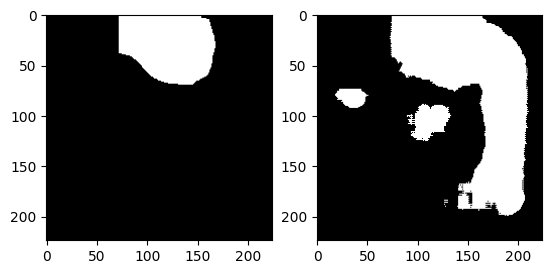

  1%|          | 1/100 [07:35<12:32:09, 455.85s/it]

training started
epoch 2 training total loss: -56.16534799448649 training dice: 0.4606126810214482 training dice loss: 0.5459732496738434 training inverse loss: 5.671132127602895
epoch 2 validation loss: 0.5455108165740967 validation dice: 0.4590451928965437


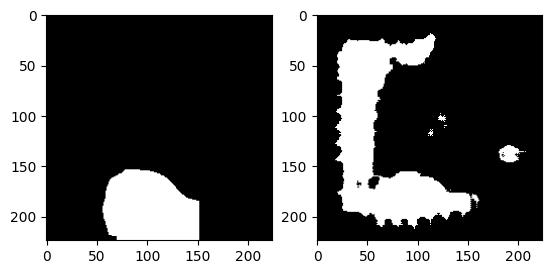

  2%|▏         | 2/100 [14:38<11:52:15, 436.08s/it]

training started
epoch 3 training total loss: -56.07625224685669 training dice: 0.47433357572561363 training dice loss: 0.5307201800346375 training inverse loss: 5.660697246710459
epoch 3 validation loss: 0.5239288409550985 validation dice: 0.4790152889117599


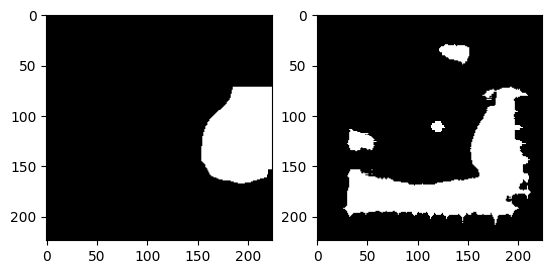

  3%|▎         | 3/100 [22:03<11:52:15, 440.57s/it]

training started
epoch 4 training total loss: -56.046976740519206 training dice: 0.4928485332926114 training dice loss: 0.5115251381397248 training inverse loss: 5.655850195089976
epoch 4 validation loss: 0.5226903863747915 validation dice: 0.47996942068139714


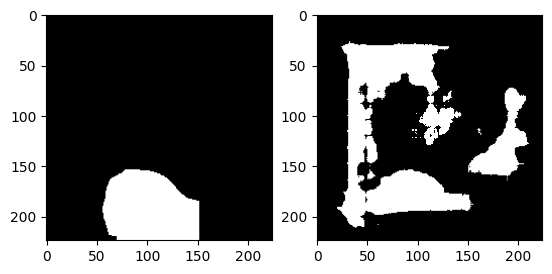

  4%|▍         | 4/100 [29:53<12:03:13, 452.02s/it]

training started
epoch 5 training total loss: -56.18138979085286 training dice: 0.49597632654441987 training dice loss: 0.5079696371555328 training inverse loss: 5.668935948053996
epoch 5 validation loss: 0.5053705592950185 validation dice: 0.4967940810322762


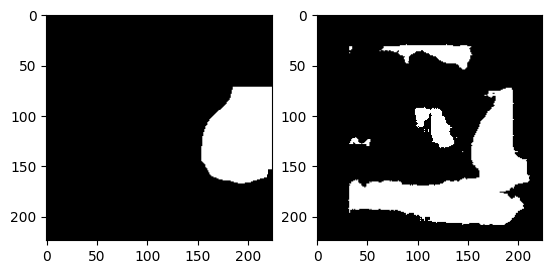

  5%|▌         | 5/100 [1:04:00<27:06:33, 1027.30s/it]

training started
epoch 6 training total loss: -56.09863744099935 training dice: 0.5149749587962094 training dice loss: 0.4888042725721995 training inverse loss: 5.658744163831075
epoch 6 validation loss: 0.5132967019081116 validation dice: 0.4893122544310366


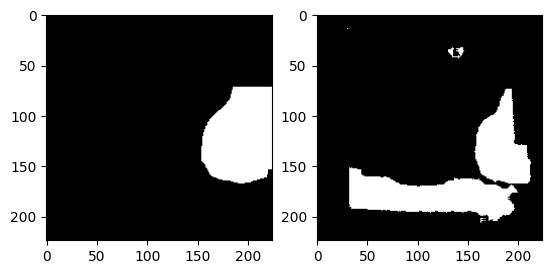

  6%|▌         | 6/100 [2:06:28<50:58:19, 1952.12s/it]

training started
epoch 7 training total loss: -56.104701662699384 training dice: 0.5241822410035335 training dice loss: 0.47928575468063356 training inverse loss: 5.658398762702942
epoch 7 validation loss: 0.5466804738839467 validation dice: 0.4562001229822636


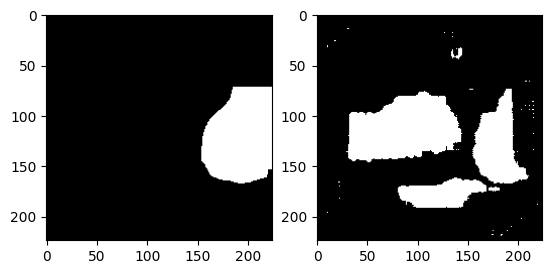

  7%|▋         | 7/100 [3:08:40<65:27:40, 2533.98s/it]

training started
epoch 8 training total loss: -56.15212010828654 training dice: 0.5297411809313732 training dice loss: 0.47356686933835346 training inverse loss: 5.6625687084197995
epoch 8 validation loss: 0.47636788368225097 validation dice: 0.524710070391496


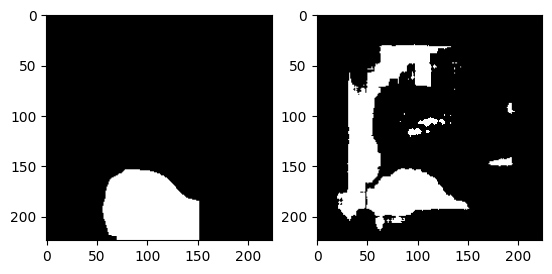

  8%|▊         | 8/100 [4:11:37<74:52:08, 2929.66s/it]

training started
epoch 9 training total loss: -56.38608256149292 training dice: 0.5563634588976857 training dice loss: 0.4469644212722778 training inverse loss: 5.683304696718852
epoch 9 validation loss: 0.45445643305778505 validation dice: 0.5475839560354749


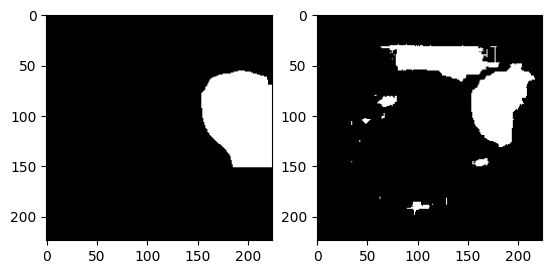

  9%|▉         | 9/100 [5:12:19<79:41:16, 3152.49s/it]

training started
epoch 10 training total loss: -56.34484955088298 training dice: 0.5709815396817187 training dice loss: 0.43211290510495504 training inverse loss: 5.677696251710256
epoch 10 validation loss: 0.45909857471783955 validation dice: 0.5426556093258357


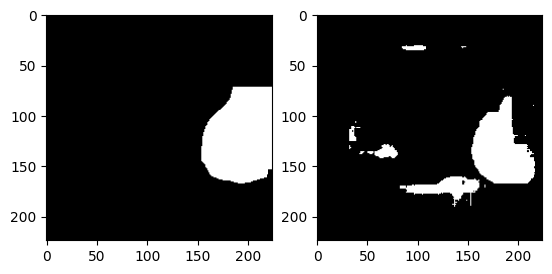

 10%|█         | 10/100 [6:16:40<84:17:02, 3371.36s/it]

training started
epoch 11 training total loss: -56.37255231221517 training dice: 0.5946374459997751 training dice loss: 0.40832861224810285 training inverse loss: 5.67808809709549
epoch 11 validation loss: 0.43069032073020935 validation dice: 0.5701630237698555


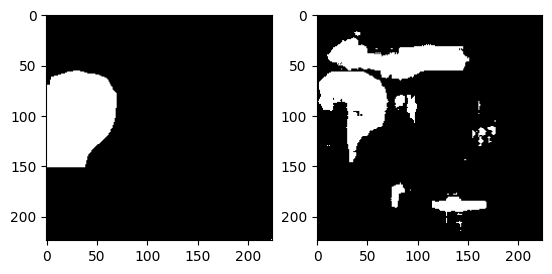

 11%|█         | 11/100 [7:20:06<86:38:05, 3504.33s/it]

training started
epoch 12 training total loss: -56.407675338745115 training dice: 0.6082791456061726 training dice loss: 0.39474211883544924 training inverse loss: 5.6802417476971945
epoch 12 validation loss: 0.4275431780020396 validation dice: 0.5749975923014183


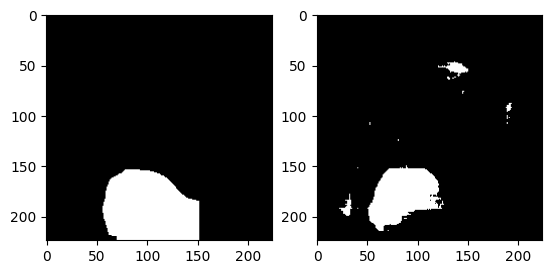

 12%|█▏        | 12/100 [8:23:16<87:46:58, 3591.12s/it]

training started
epoch 13 training total loss: -56.19502226257324 training dice: 0.6306328152654072 training dice loss: 0.372493501106898 training inverse loss: 5.656751572608948
epoch 13 validation loss: 0.4230665636062622 validation dice: 0.5807811878124873


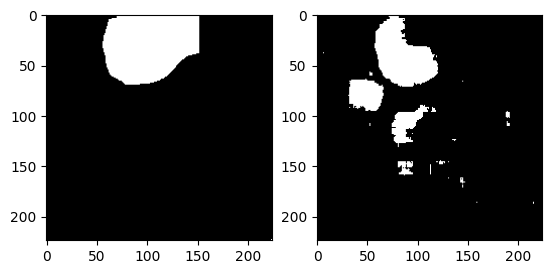

 13%|█▎        | 13/100 [9:26:37<88:19:17, 3654.69s/it]

training started
epoch 14 training total loss: -56.481196329752606 training dice: 0.6474458330618218 training dice loss: 0.3561392637093862 training inverse loss: 5.683733564376831
epoch 14 validation loss: 0.39280723651250204 validation dice: 0.6085599385232975


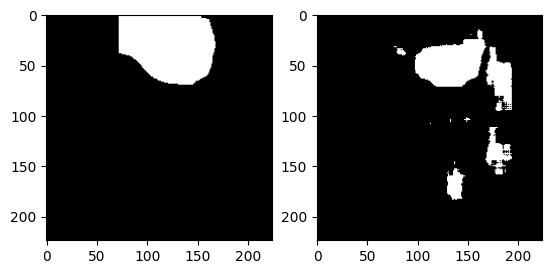

 14%|█▍        | 14/100 [10:27:08<87:08:06, 3647.51s/it]

training started
epoch 15 training total loss: -56.29744668833415 training dice: 0.6607033946265777 training dice loss: 0.3429822855790456 training inverse loss: 5.664042899449666
epoch 15 validation loss: 0.3579128460089366 validation dice: 0.6444429761171341


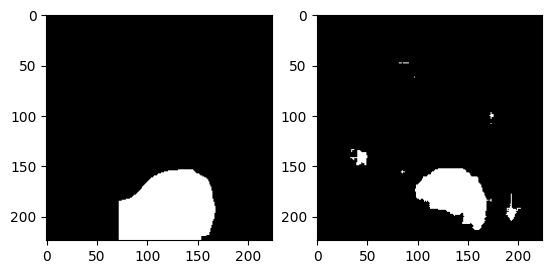

 15%|█▌        | 15/100 [11:29:05<86:36:53, 3668.39s/it]

training started
epoch 16 training total loss: -56.4794283396403 training dice: 0.6763104385631159 training dice loss: 0.3277455925941467 training inverse loss: 5.680717387994131
epoch 16 validation loss: 0.36290592948595685 validation dice: 0.6386650529379646


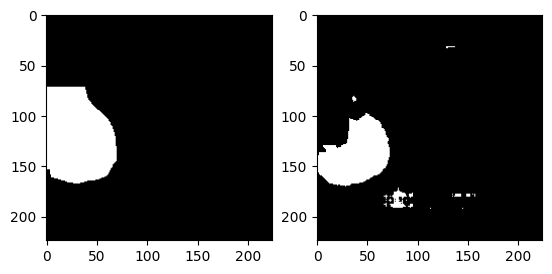

 16%|█▌        | 16/100 [12:30:03<85:31:24, 3665.29s/it]

training started
epoch 17 training total loss: -56.41482761383057 training dice: 0.6901845728655657 training dice loss: 0.3138313562075297 training inverse loss: 5.67286589606603
epoch 17 validation loss: 0.342306832075119 validation dice: 0.6624314512809117


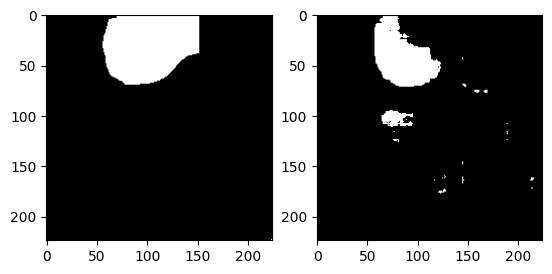

 17%|█▋        | 17/100 [13:32:13<84:57:11, 3684.71s/it]

training started
epoch 18 training total loss: -56.63634713236491 training dice: 0.6965438250750303 training dice loss: 0.30795526591936745 training inverse loss: 5.694430235862732
epoch 18 validation loss: 0.3341344610850016 validation dice: 0.6709278647353252


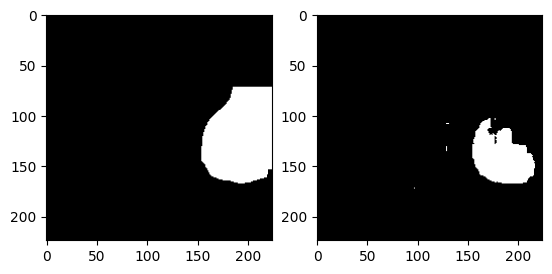

 18%|█▊        | 18/100 [14:32:44<83:33:48, 3668.64s/it]

training started
epoch 19 training total loss: -56.37626128387451 training dice: 0.7151640709375885 training dice loss: 0.28938212744394937 training inverse loss: 5.666564351876577
epoch 19 validation loss: 0.33065337300300596 validation dice: 0.6752625552813212


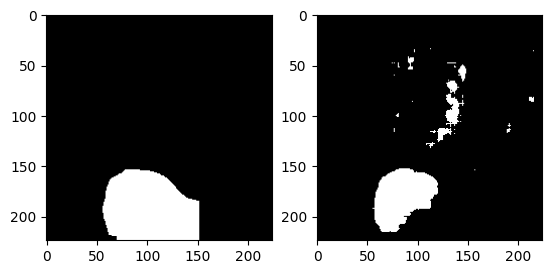

 19%|█▉        | 19/100 [15:33:27<82:22:31, 3661.13s/it]

training started
epoch 20 training total loss: -56.44477430470784 training dice: 0.7168266330840998 training dice loss: 0.2874870634078979 training inverse loss: 5.673226143519083
epoch 20 validation loss: 0.31715087334314984 validation dice: 0.6883424996336301


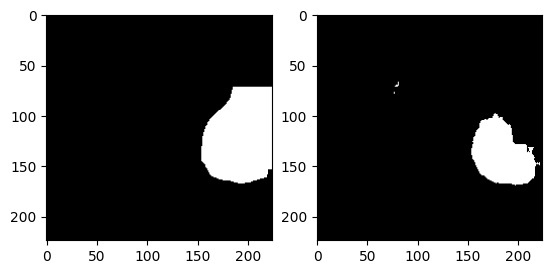

 20%|██        | 20/100 [16:35:41<81:50:32, 3682.91s/it]

training started
epoch 21 training total loss: -56.26610756810506 training dice: 0.7296875381168599 training dice loss: 0.27499135613441467 training inverse loss: 5.654109894593557
epoch 21 validation loss: 0.31168739159901937 validation dice: 0.6922529406224688


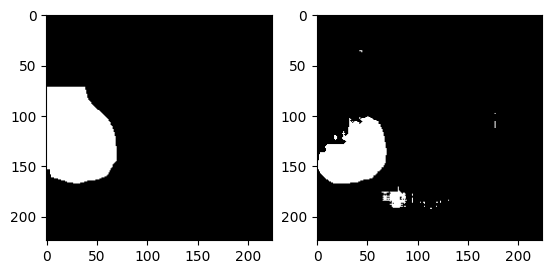

 21%|██        | 21/100 [17:34:55<79:58:19, 3644.30s/it]

training started
epoch 22 training total loss: -56.419636993408204 training dice: 0.7339768610671162 training dice loss: 0.2705117907524109 training inverse loss: 5.669014885584513
epoch 22 validation loss: 0.3074932924906413 validation dice: 0.6974341559037566


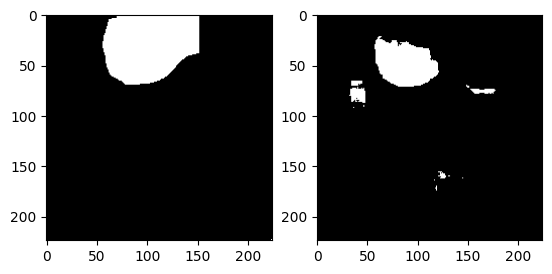

 22%|██▏       | 22/100 [18:32:51<77:51:45, 3593.66s/it]

training started
epoch 23 training total loss: -56.26217027537028 training dice: 0.7445770112459238 training dice loss: 0.2600672456423442 training inverse loss: 5.65222375090917
epoch 23 validation loss: 0.2973094069957733 validation dice: 0.7064427466255924
model saved


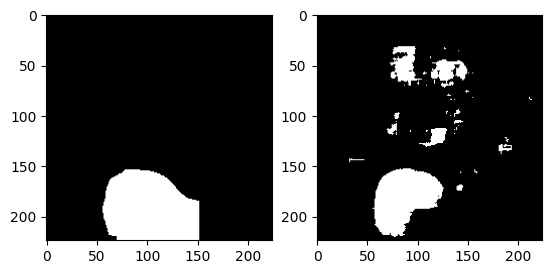

 23%|██▎       | 23/100 [19:35:06<77:46:07, 3635.94s/it]

training started
epoch 24 training total loss: -56.59764387257894 training dice: 0.7488865061697628 training dice loss: 0.25545772337913514 training inverse loss: 5.68531015253067
epoch 24 validation loss: 0.2953848858674367 validation dice: 0.7098565788318714
model saved


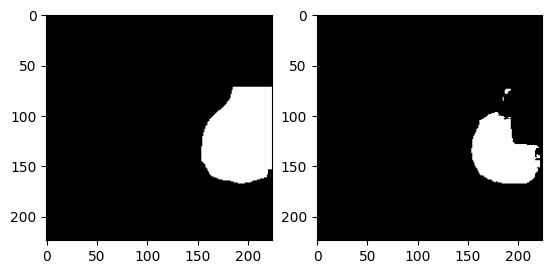

 24%|██▍       | 24/100 [20:36:02<76:53:26, 3642.19s/it]

training started
epoch 25 training total loss: -56.53406269836426 training dice: 0.752081257730218 training dice loss: 0.2523954203128815 training inverse loss: 5.67864581378301
epoch 25 validation loss: 0.29583877325057983 validation dice: 0.7078690375636021
model saved


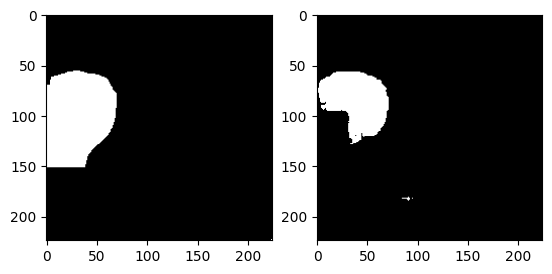

 25%|██▌       | 25/100 [21:39:46<77:00:56, 3696.76s/it]

training started
epoch 26 training total loss: -56.55985635121663 training dice: 0.7583507844854612 training dice loss: 0.24617368936538697 training inverse loss: 5.680603000322978
epoch 26 validation loss: 0.291625101963679 validation dice: 0.7130447137231628
model saved


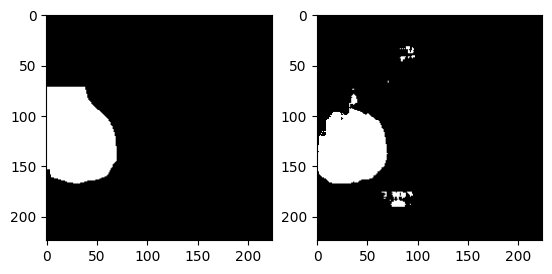

 26%|██▌       | 26/100 [22:42:13<76:17:50, 3711.76s/it]

training started
epoch 27 training total loss: -56.56676577504476 training dice: 0.7629661462940276 training dice loss: 0.24157163858413697 training inverse loss: 5.680833742459615
epoch 27 validation loss: 0.26786437511444094 validation dice: 0.7377289592971404
model saved


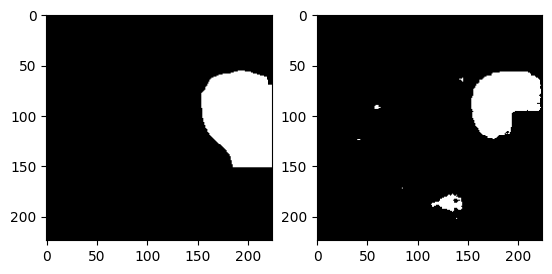

 27%|██▋       | 27/100 [23:46:34<76:10:20, 3756.45s/it]

training started
epoch 28 training total loss: -56.3520524520874 training dice: 0.7727672740966082 training dice loss: 0.23197013107935588 training inverse loss: 5.658402268409729
epoch 28 validation loss: 0.27208125750223794 validation dice: 0.7328095187743505
model saved


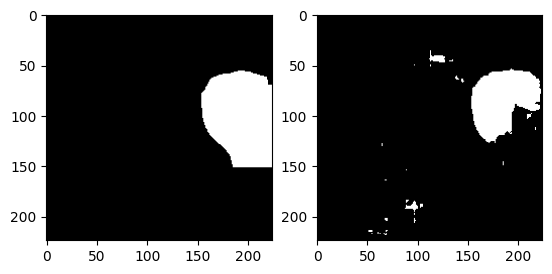

 28%|██▊       | 28/100 [24:48:20<74:49:29, 3741.24s/it]

training started
epoch 29 training total loss: -56.55644745381673 training dice: 0.7745820599397023 training dice loss: 0.23006853342056274 training inverse loss: 5.678651603221893
epoch 29 validation loss: 0.28310015439987185 validation dice: 0.7204765164355437
model saved


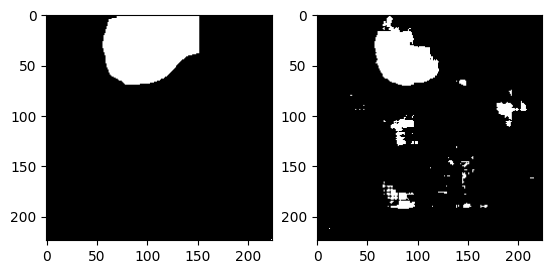

 29%|██▉       | 29/100 [25:48:28<72:59:59, 3701.40s/it]

training started
epoch 30 training total loss: -56.67327224477132 training dice: 0.7780912327715196 training dice loss: 0.22604244216283162 training inverse loss: 5.689931478182475
epoch 30 validation loss: 0.2796075463294983 validation dice: 0.7264435027043025
model saved


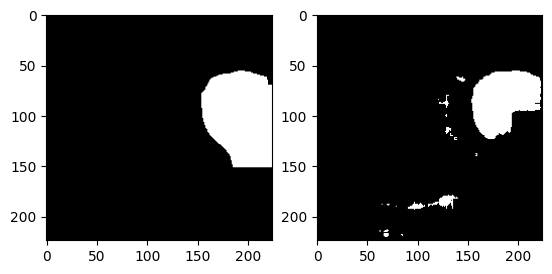

 30%|███       | 30/100 [26:47:33<71:03:44, 3654.63s/it]

training started
epoch 31 training total loss: -56.813149915059405 training dice: 0.7790156707999607 training dice loss: 0.2253522299925486 training inverse loss: 5.703850220044454
epoch 31 validation loss: 0.27600658853848775 validation dice: 0.729679113564392
model saved


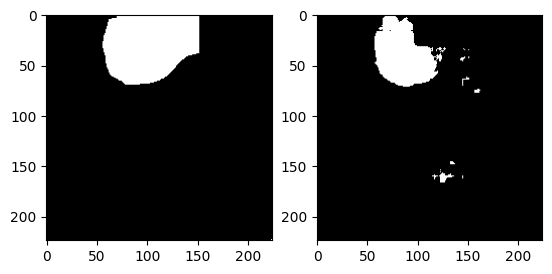

 31%|███       | 31/100 [27:48:14<69:58:02, 3650.47s/it]

training started
epoch 32 training total loss: -56.44704515329997 training dice: 0.7867940959228824 training dice loss: 0.21757947643597922 training inverse loss: 5.666462471644084
epoch 32 validation loss: 0.2731660254796346 validation dice: 0.730664731853952
model saved


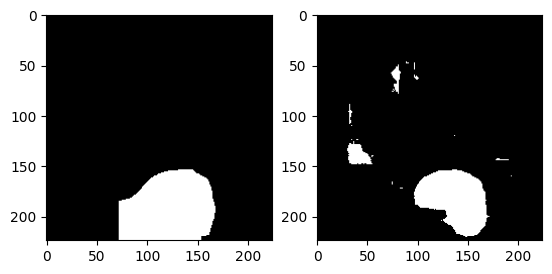

 32%|███▏      | 32/100 [28:50:24<69:24:15, 3674.34s/it]

training started
epoch 33 training total loss: -56.33065835316976 training dice: 0.7862461621602609 training dice loss: 0.21802730862299602 training inverse loss: 5.654868581771851
epoch 33 validation loss: 0.26977686723073324 validation dice: 0.7354868074754873
model saved


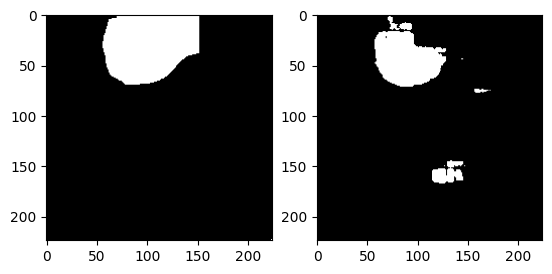

 33%|███▎      | 33/100 [29:53:17<68:55:54, 3703.80s/it]

training started
epoch 34 training total loss: -56.51229001363119 training dice: 0.794561818706803 training dice loss: 0.20949843128522236 training inverse loss: 5.672178839206696
epoch 34 validation loss: 0.2686887669563294 validation dice: 0.7366039058069388
model saved


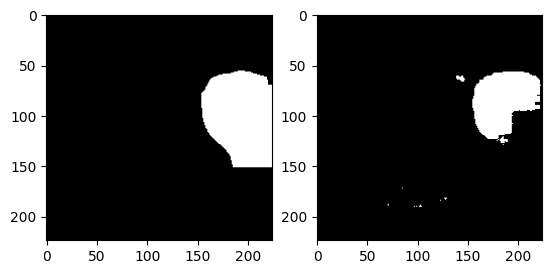

 34%|███▍      | 34/100 [30:56:08<68:16:24, 3724.01s/it]

training started
epoch 35 training total loss: -56.32764730834961 training dice: 0.7962850772266586 training dice loss: 0.20787836424509684 training inverse loss: 5.653552574157715
epoch 35 validation loss: 0.26538633902867637 validation dice: 0.7399294843276342
model saved


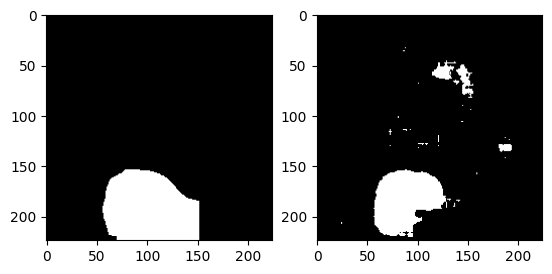

 35%|███▌      | 35/100 [31:56:26<66:39:57, 3692.26s/it]

training started
epoch 36 training total loss: -56.582503041585284 training dice: 0.795013215478044 training dice loss: 0.20884514776865643 training inverse loss: 5.679134821891784
epoch 36 validation loss: 0.2640114696820577 validation dice: 0.741537222067515
model saved


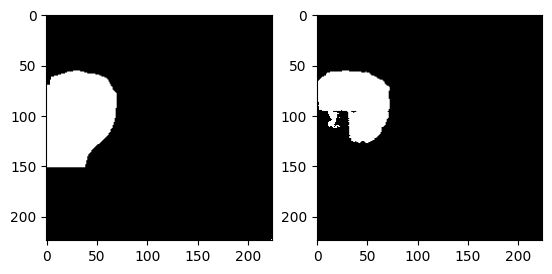

 36%|███▌      | 36/100 [32:56:14<65:05:03, 3661.00s/it]

training started
epoch 37 training total loss: -56.597021231333414 training dice: 0.8005612469837069 training dice loss: 0.20330855719248453 training inverse loss: 5.680032987435659
epoch 37 validation loss: 0.2574314916133881 validation dice: 0.7474666870161308
model saved


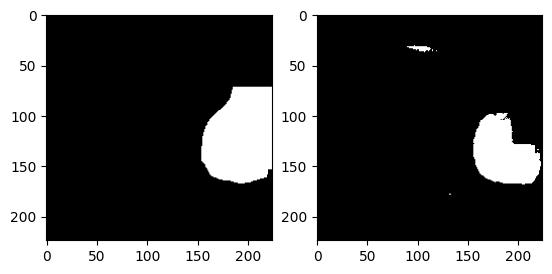

 37%|███▋      | 37/100 [33:57:55<64:16:37, 3672.98s/it]

training started
epoch 38 training total loss: -56.49660599517822 training dice: 0.8025901219124595 training dice loss: 0.2012807055314382 training inverse loss: 5.669788685798645
epoch 38 validation loss: 0.2649605063597361 validation dice: 0.7395826859523853
model saved


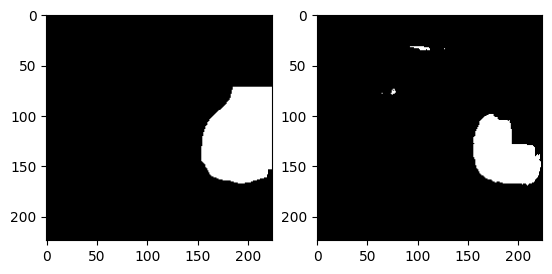

 38%|███▊      | 38/100 [34:56:45<62:31:00, 3630.00s/it]

training started
epoch 39 training total loss: -56.65904833348592 training dice: 0.8085754554023346 training dice loss: 0.1954942208925883 training inverse loss: 5.685454262256623
epoch 39 validation loss: 0.2596149516105652 validation dice: 0.7439326905210812
model saved


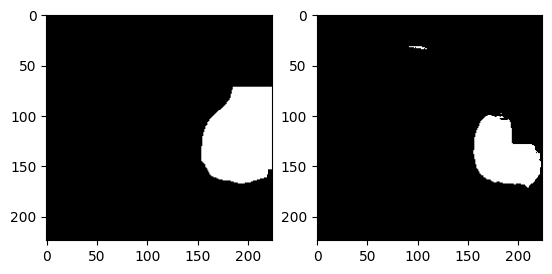

 39%|███▉      | 39/100 [35:56:50<61:22:46, 3622.41s/it]

training started
epoch 40 training total loss: -56.72774245961507 training dice: 0.8099513446103471 training dice loss: 0.19387244160970052 training inverse loss: 5.692161488691966
epoch 40 validation loss: 0.26415393471717835 validation dice: 0.7410669332556427
model saved


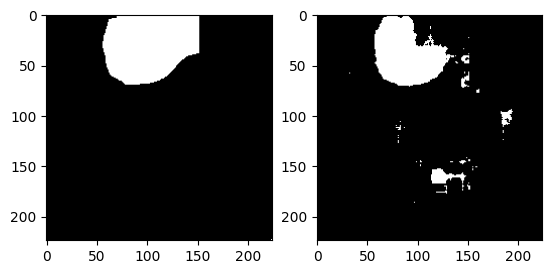

 40%|████      | 40/100 [36:55:29<59:51:23, 3591.38s/it]

training started
epoch 41 training total loss: -56.29014143371582 training dice: 0.8121958812028169 training dice loss: 0.19182231084505716 training inverse loss: 5.6481963815689085
epoch 41 validation loss: 0.2721969763437907 validation dice: 0.7331299528107047
model saved


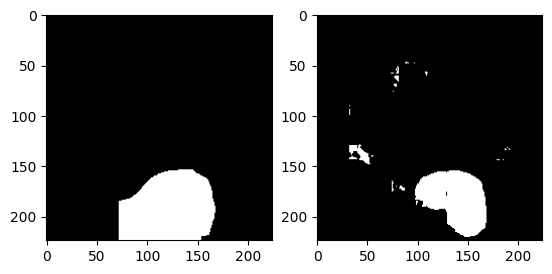

 41%|████      | 41/100 [37:54:14<58:32:02, 3571.56s/it]

training started
epoch 42 training total loss: -56.587600372314455 training dice: 0.8090423755945327 training dice loss: 0.19476814325650532 training inverse loss: 5.678236861387888
epoch 42 validation loss: 0.2568445463975271 validation dice: 0.7477712461849054
model saved


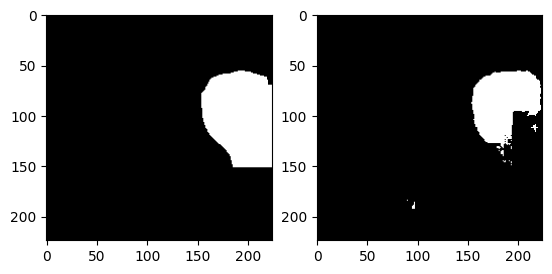

 42%|████▏     | 42/100 [38:35:57<52:22:41, 3251.06s/it]

training started
epoch 43 training total loss: -56.271176100413 training dice: 0.8161503991167992 training dice loss: 0.18759475406010945 training inverse loss: 5.645877081712087
epoch 43 validation loss: 0.2597912057240804 validation dice: 0.7450324039714178
model saved


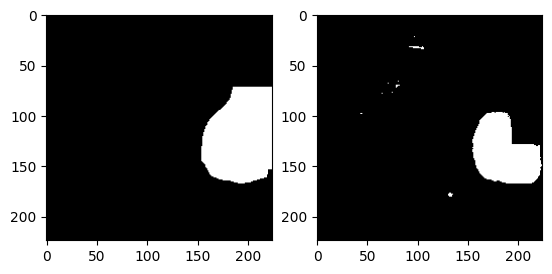

 43%|████▎     | 43/100 [38:43:02<38:03:06, 2403.27s/it]

training started
epoch 44 training total loss: -56.485076684316 training dice: 0.816110330109795 training dice loss: 0.1876356997489929 training inverse loss: 5.6672712456385295
epoch 44 validation loss: 0.2705118680000305 validation dice: 0.7350424976057063
model saved


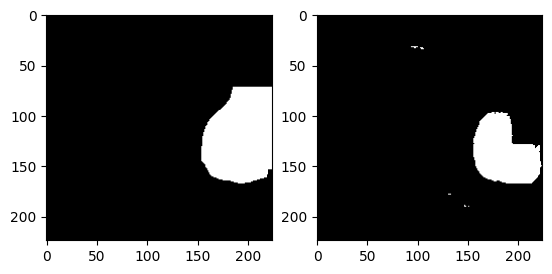

 44%|████▍     | 44/100 [38:50:10<28:09:50, 1810.54s/it]

training started
epoch 45 training total loss: -56.710063897450766 training dice: 0.8176040119330088 training dice loss: 0.18618100468317667 training inverse loss: 5.6896244792938235
epoch 45 validation loss: 0.2549680201212565 validation dice: 0.750340902741688
model saved


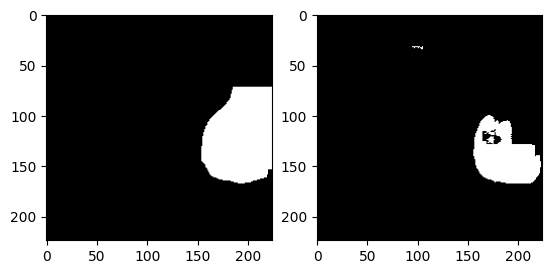

 45%|████▌     | 45/100 [38:57:15<21:18:42, 1394.95s/it]

training started
epoch 46 training total loss: -56.63450780359904 training dice: 0.8179273879478375 training dice loss: 0.1855566755135854 training inverse loss: 5.682006453990936
epoch 46 validation loss: 0.25658392190933227 validation dice: 0.748830452611049
model saved


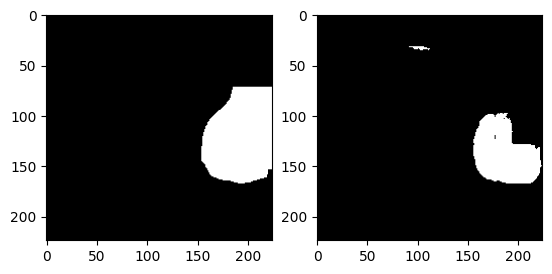

 46%|████▌     | 46/100 [39:04:01<16:28:22, 1098.20s/it]

training started
epoch 47 training total loss: -56.50090268707275 training dice: 0.8202305217509468 training dice loss: 0.18324336862564086 training inverse loss: 5.6684146202405294
epoch 47 validation loss: 0.2584740964571635 validation dice: 0.7456855885932843
model saved


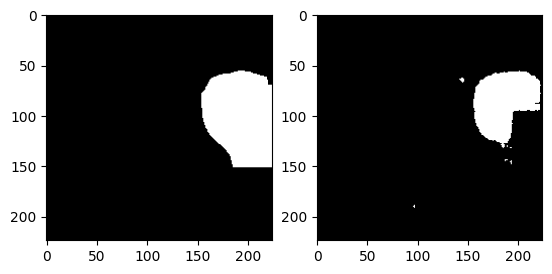

 47%|████▋     | 47/100 [39:10:50<13:07:35, 891.61s/it] 

training started
epoch 48 training total loss: -56.41116669464111 training dice: 0.8256568977882465 training dice loss: 0.17797759620348613 training inverse loss: 5.658914450804392
epoch 48 validation loss: 0.24369998653729757 validation dice: 0.7611326027164856
model saved


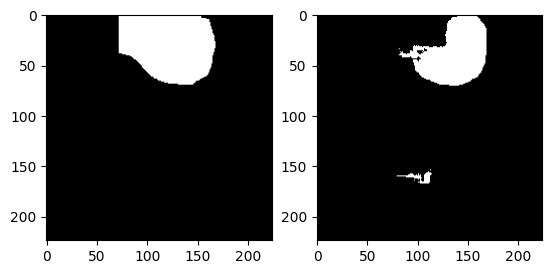

 48%|████▊     | 48/100 [39:17:42<10:48:04, 747.77s/it]

training started
epoch 49 training total loss: -56.55499745178223 training dice: 0.8282301838596662 training dice loss: 0.1756590255101522 training inverse loss: 5.673065656661987
epoch 49 validation loss: 0.2559648414452871 validation dice: 0.7500918594871958
model saved


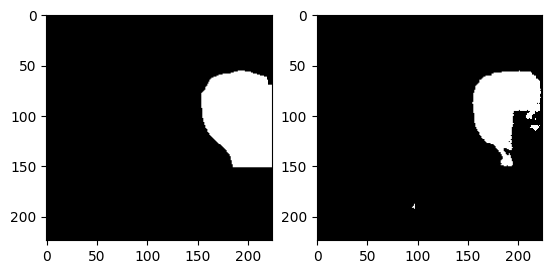

 49%|████▉     | 49/100 [39:25:24<9:22:32, 661.81s/it] 

training started
epoch 50 training total loss: -56.57414194234212 training dice: 0.824909164428711 training dice loss: 0.1786932144165039 training inverse loss: 5.6752835214932755
epoch 50 validation loss: 0.2500443669160207 validation dice: 0.755253462990125
model saved


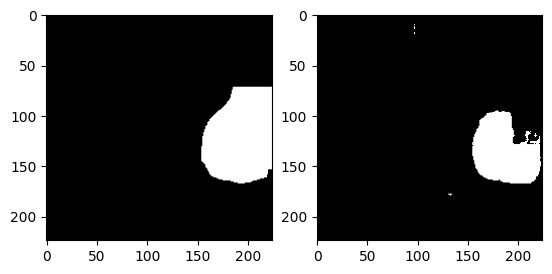

 50%|█████     | 50/100 [39:32:41<8:15:30, 594.60s/it]

training started
epoch 51 training total loss: -56.53397881317139 training dice: 0.8269561574508747 training dice loss: 0.17645087202390036 training inverse loss: 5.671042977015177
epoch 51 validation loss: 0.24272035638491313 validation dice: 0.7620996792117755
model saved


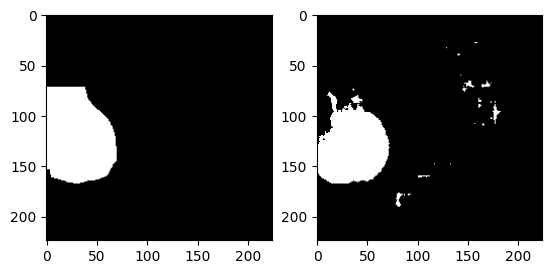

 51%|█████     | 51/100 [39:39:33<7:20:46, 539.73s/it]

training started
epoch 52 training total loss: -56.878157862345375 training dice: 0.8345670196712017 training dice loss: 0.16892867358525593 training inverse loss: 5.704708658854167
epoch 52 validation loss: 0.24602108875910442 validation dice: 0.7578698374703526
model saved


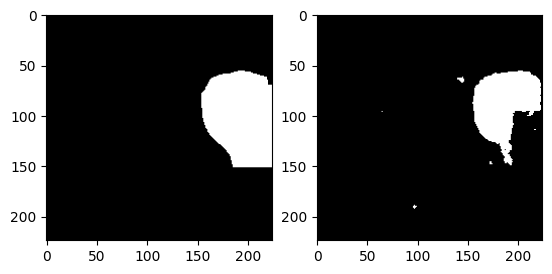

 52%|█████▏    | 52/100 [39:47:46<7:00:26, 525.54s/it]

training started
epoch 53 training total loss: -56.51909276072184 training dice: 0.8315970892397065 training dice loss: 0.17178527410825092 training inverse loss: 5.669087799549103
epoch 53 validation loss: 0.24331828713417053 validation dice: 0.7603813803816835
model saved


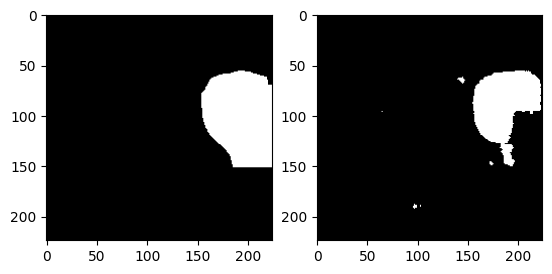

 53%|█████▎    | 53/100 [39:54:36<6:24:34, 490.95s/it]

training started
epoch 54 training total loss: -56.60305095163981 training dice: 0.8336763148630659 training dice loss: 0.16997499465942384 training inverse loss: 5.677302594343821
epoch 54 validation loss: 0.24977901697158814 validation dice: 0.7559355366664628
model saved


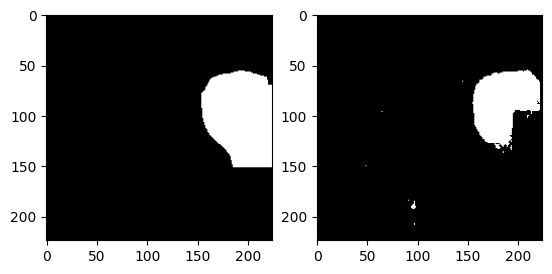

 54%|█████▍    | 54/100 [40:02:30<6:12:28, 485.84s/it]

training started
epoch 55 training total loss: -56.461852639516195 training dice: 0.8364914347827435 training dice loss: 0.16704410648345946 training inverse loss: 5.662889685153961
epoch 55 validation loss: 0.25065617481867475 validation dice: 0.7540261070476845
model saved


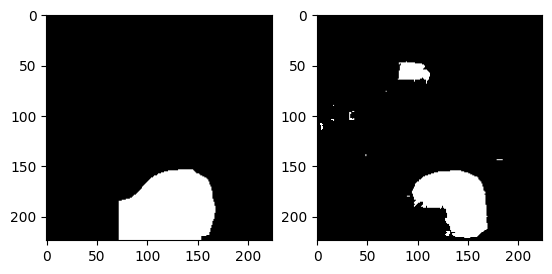

 55%|█████▌    | 55/100 [40:09:54<5:54:59, 473.32s/it]

training started
epoch 56 training total loss: -56.67005647277832 training dice: 0.8359560201500232 training dice loss: 0.16752018960316975 training inverse loss: 5.683757663091024
epoch 56 validation loss: 0.24478361368179322 validation dice: 0.7601269629659752
model saved


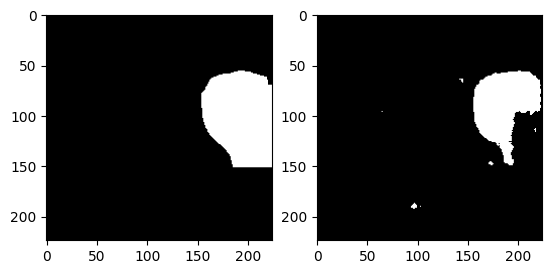

 56%|█████▌    | 56/100 [40:18:07<5:51:25, 479.21s/it]

training started
epoch 57 training total loss: -56.659740847269696 training dice: 0.8328462476059795 training dice loss: 0.17066701285044353 training inverse loss: 5.683040794531505
epoch 57 validation loss: 0.24641278266906738 validation dice: 0.7573459643746415
model saved


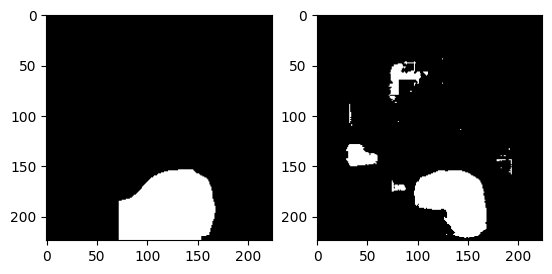

 57%|█████▋    | 57/100 [40:25:50<5:40:00, 474.44s/it]

training started
epoch 58 training total loss: -56.4085742594401 training dice: 0.8368119522978862 training dice loss: 0.16666569304466247 training inverse loss: 5.657523989995321
epoch 58 validation loss: 0.24663901845614114 validation dice: 0.7569790596763293
model saved


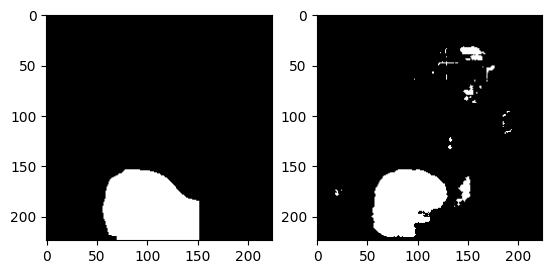

 58%|█████▊    | 58/100 [40:32:58<5:22:19, 460.45s/it]

training started
epoch 59 training total loss: -56.42396440887451 training dice: 0.8365861252518371 training dice loss: 0.1667522644996643 training inverse loss: 5.659071672280629
epoch 59 validation loss: 0.24432589173316954 validation dice: 0.7608830252538125
model saved


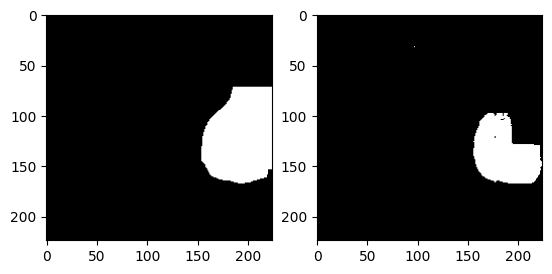

 59%|█████▉    | 59/100 [40:41:43<5:27:56, 479.90s/it]

training started
epoch 60 training total loss: -56.772763919830325 training dice: 0.8399778299331665 training dice loss: 0.16362478748957315 training inverse loss: 5.693638877868652
epoch 60 validation loss: 0.24513418634732564 validation dice: 0.758318046281735
model saved


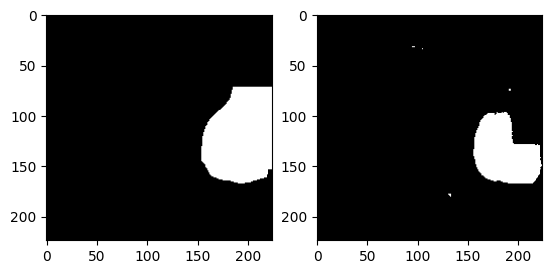

 60%|██████    | 60/100 [40:49:53<5:21:55, 482.88s/it]

training started
epoch 61 training total loss: -56.56480944697062 training dice: 0.8392453160881996 training dice loss: 0.1641806780497233 training inverse loss: 5.67289901304245
epoch 61 validation loss: 0.2501701676845551 validation dice: 0.7545400206496318
model saved


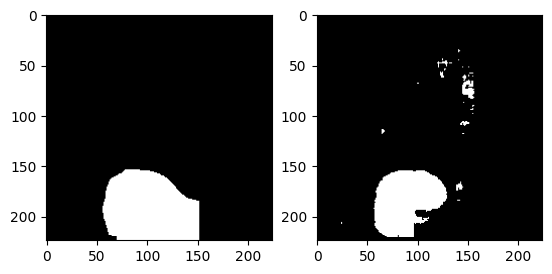

 61%|██████    | 61/100 [40:56:52<5:01:25, 463.74s/it]

training started
epoch 62 training total loss: -56.63664352162679 training dice: 0.8422982030510903 training dice loss: 0.16130574854214985 training inverse loss: 5.679794934272766
epoch 62 validation loss: 0.2517897379398346 validation dice: 0.7523186729041239
model saved


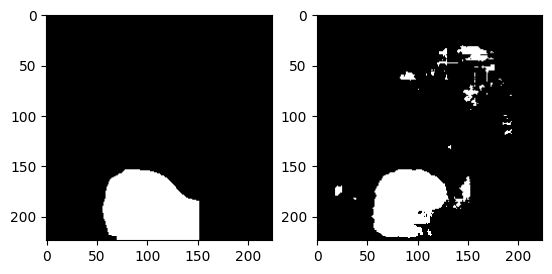

 62%|██████▏   | 62/100 [41:04:24<4:51:29, 460.24s/it]

training started
epoch 63 training total loss: -56.545210264841714 training dice: 0.8396764785299698 training dice loss: 0.16392120416959127 training inverse loss: 5.670913151423137
epoch 63 validation loss: 0.24974562605222067 validation dice: 0.754516433229049
model saved


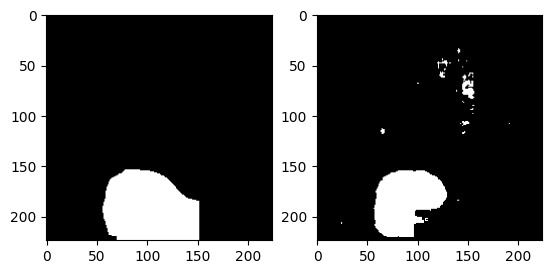

 63%|██████▎   | 63/100 [41:11:21<4:35:45, 447.17s/it]

training started
epoch 64 training total loss: -56.42186154301961 training dice: 0.842304260780414 training dice loss: 0.16101213463147482 training inverse loss: 5.658287374655406
epoch 64 validation loss: 0.25059149106343587 validation dice: 0.7539724774161974
model saved


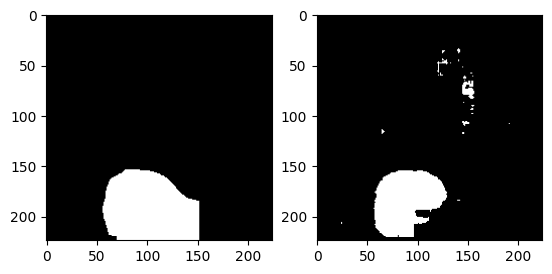

 64%|██████▍   | 64/100 [41:18:24<4:24:00, 440.02s/it]

training started
epoch 65 training total loss: -56.47093428548177 training dice: 0.8442652444789807 training dice loss: 0.1593092167377472 training inverse loss: 5.66302435652415
epoch 65 validation loss: 0.24092378934224445 validation dice: 0.7629606775194406
model saved


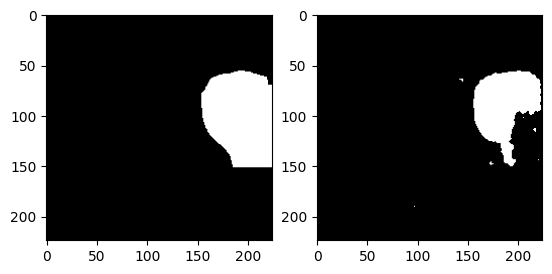

 65%|██████▌   | 65/100 [41:25:28<4:13:46, 435.03s/it]

training started
epoch 66 training total loss: -56.67066018931071 training dice: 0.8446258691300949 training dice loss: 0.15861646262804668 training inverse loss: 5.6829276588757835
epoch 66 validation loss: 0.24930686950683595 validation dice: 0.7554866475425661
model saved


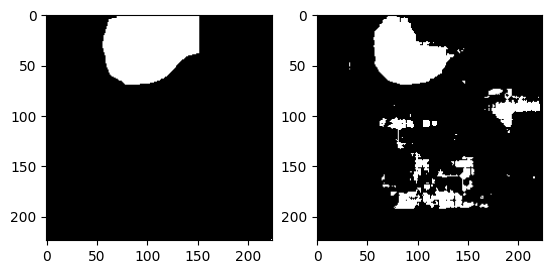

 66%|██████▌   | 66/100 [41:32:24<4:03:18, 429.37s/it]

training started
epoch 67 training total loss: -56.56447214253743 training dice: 0.842885345886151 training dice loss: 0.16078024101257324 training inverse loss: 5.672525238990784
epoch 67 validation loss: 0.24378361384073893 validation dice: 0.760193763418744
model saved


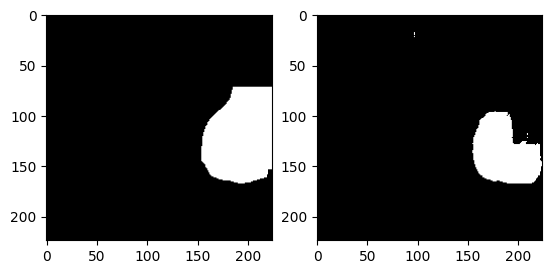

 67%|██████▋   | 67/100 [41:40:25<4:04:44, 444.98s/it]

training started
epoch 68 training total loss: -56.65405330912272 training dice: 0.844011876364549 training dice loss: 0.15960108192761738 training inverse loss: 5.68136544307073
epoch 68 validation loss: 0.24093478798866272 validation dice: 0.7626458824891597
model saved


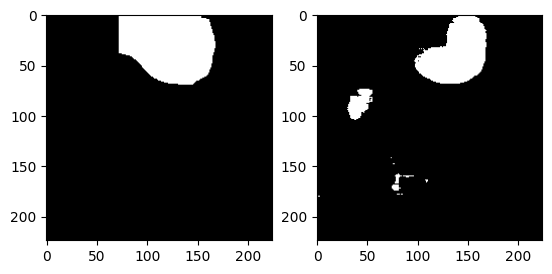

 68%|██████▊   | 68/100 [41:47:53<3:57:44, 445.76s/it]

training started
epoch 69 training total loss: -56.49870236714681 training dice: 0.846064819479982 training dice loss: 0.15719923599561056 training inverse loss: 5.665590154965718
epoch 69 validation loss: 0.24268490076065063 validation dice: 0.7617160021016995
model saved


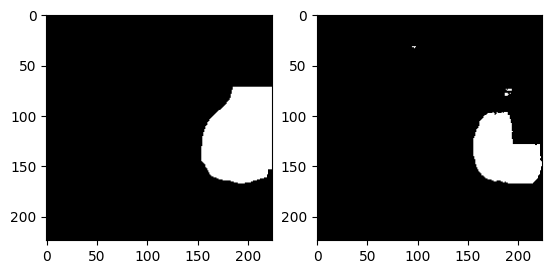

 69%|██████▉   | 69/100 [41:55:02<3:47:40, 440.67s/it]

training started
epoch 70 training total loss: -56.28103224436442 training dice: 0.8451676980033517 training dice loss: 0.15810200087229412 training inverse loss: 5.643913430213928
epoch 70 validation loss: 0.24271600445111594 validation dice: 0.7616464178264141
model saved


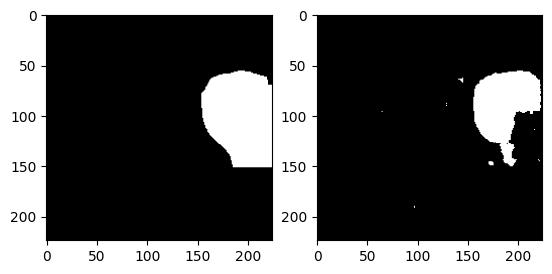

 70%|███████   | 70/100 [42:02:03<3:37:24, 434.83s/it]

training started
epoch 71 training total loss: -56.564423212687174 training dice: 0.8475867034445206 training dice loss: 0.1557137970129649 training inverse loss: 5.672013699690501
epoch 71 validation loss: 0.23975470503171284 validation dice: 0.7644754260530074
model saved


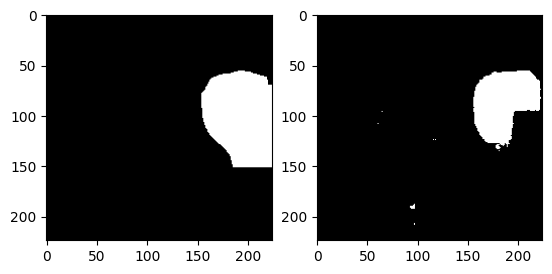

 71%|███████   | 71/100 [42:09:03<3:28:05, 430.55s/it]

training started
epoch 72 training total loss: -56.45835823694865 training dice: 0.8456876329125953 training dice loss: 0.15744530534744264 training inverse loss: 5.661580359458923
epoch 72 validation loss: 0.24662610133488974 validation dice: 0.7579965185125669
model saved


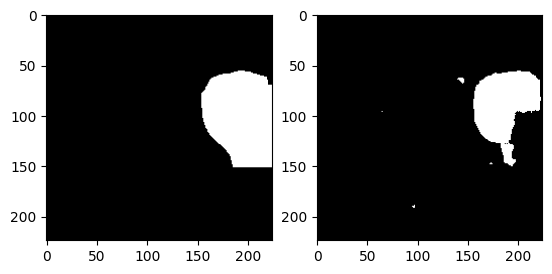

 72%|███████▏  | 72/100 [42:15:50<3:17:31, 423.27s/it]

training started
epoch 73 training total loss: -56.41958119837443 training dice: 0.8464603229264418 training dice loss: 0.15674764204025268 training inverse loss: 5.657632884025574
epoch 73 validation loss: 0.24658387939135235 validation dice: 0.7573334250847499
model saved


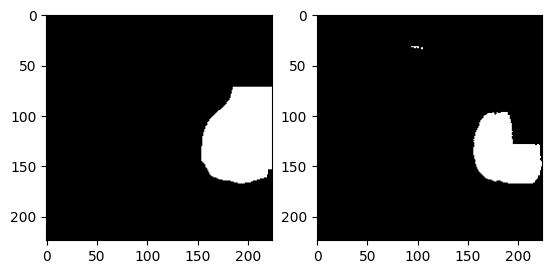

 73%|███████▎  | 73/100 [42:23:32<3:15:47, 435.09s/it]

training started
epoch 74 training total loss: -56.45602895609538 training dice: 0.8472228445817406 training dice loss: 0.15602229007085164 training inverse loss: 5.6612051320075985
epoch 74 validation loss: 0.24994508465131124 validation dice: 0.7543877890519798
model saved


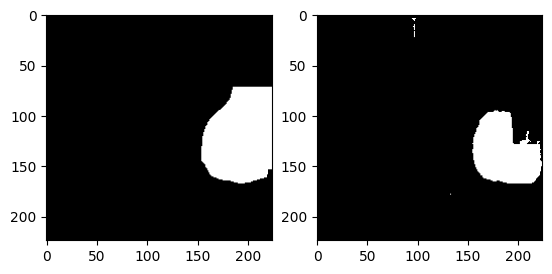

 74%|███████▍  | 74/100 [42:30:09<3:03:35, 423.67s/it]

training started
epoch 75 training total loss: -56.38474713770548 training dice: 0.846292577902476 training dice loss: 0.15703748830159506 training inverse loss: 5.654178480148316
epoch 75 validation loss: 0.23998327533404032 validation dice: 0.7637759767162303
model saved


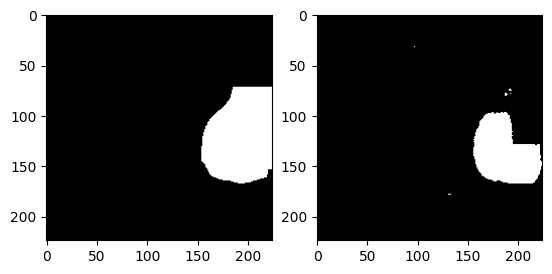

 75%|███████▌  | 75/100 [42:37:28<2:58:27, 428.29s/it]

training started
epoch 76 training total loss: -56.407695913950604 training dice: 0.8469285514699295 training dice loss: 0.15648672501246133 training inverse loss: 5.656418274561564
epoch 76 validation loss: 0.24137104709943136 validation dice: 0.7629759063323339
model saved


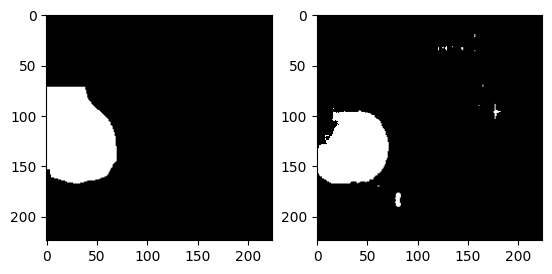

 76%|███████▌  | 76/100 [42:45:19<2:56:27, 441.13s/it]

training started
epoch 77 training total loss: -56.43605716832479 training dice: 0.8496519104987383 training dice loss: 0.15376895197232565 training inverse loss: 5.658982612768809
epoch 77 validation loss: 0.24608578046162924 validation dice: 0.7580844645543645
model saved


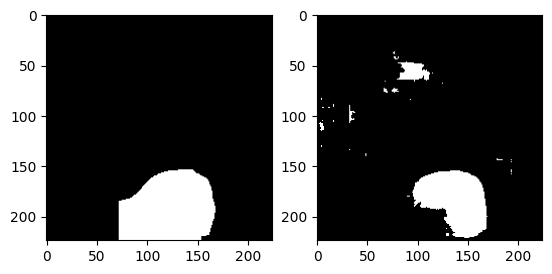

 77%|███████▋  | 77/100 [42:52:05<2:44:58, 430.36s/it]

training started
epoch 78 training total loss: -56.75663562647502 training dice: 0.847517599388957 training dice loss: 0.1557455149491628 training inverse loss: 5.69123812007904
epoch 78 validation loss: 0.2381905198097229 validation dice: 0.7658398149286707
model saved


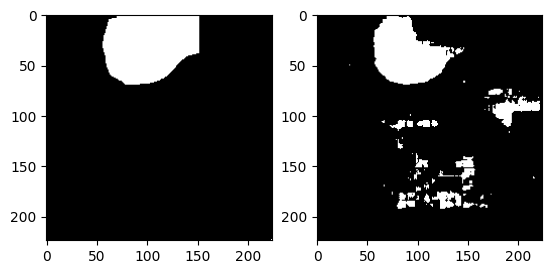

 78%|███████▊  | 78/100 [42:58:58<2:35:56, 425.31s/it]

training started
epoch 79 training total loss: -56.33859502410888 training dice: 0.8491076696856569 training dice loss: 0.15414726146062216 training inverse loss: 5.649274234771728
epoch 79 validation loss: 0.24449343085289002 validation dice: 0.7604579843084017
model saved


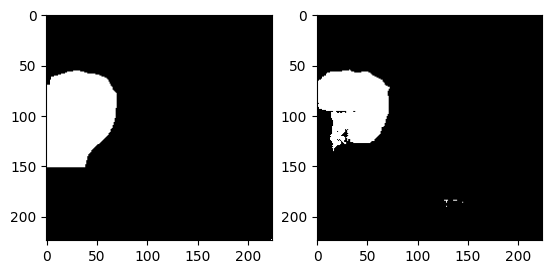

 79%|███████▉  | 79/100 [43:05:59<2:28:20, 423.85s/it]

training started
epoch 80 training total loss: -56.579718055725095 training dice: 0.8490809949239095 training dice loss: 0.15418806385993958 training inverse loss: 5.67339061276118
epoch 80 validation loss: 0.23843736131985982 validation dice: 0.7657240636522571
model saved


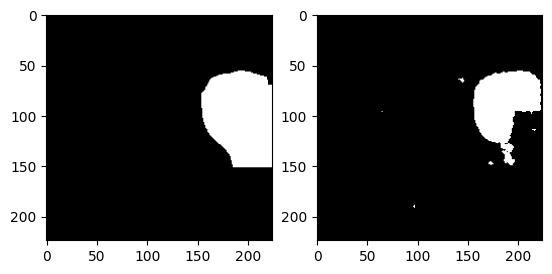

 80%|████████  | 80/100 [43:12:45<2:19:31, 418.59s/it]

training started
epoch 81 training total loss: -56.49605951436361 training dice: 0.8472972080260516 training dice loss: 0.1558848269780477 training inverse loss: 5.665194429397583
epoch 81 validation loss: 0.24247496883074443 validation dice: 0.7613881890848279
model saved


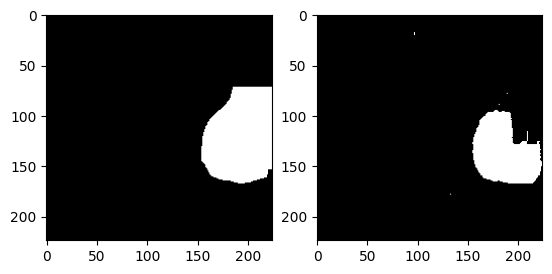

 81%|████████  | 81/100 [43:19:41<2:12:17, 417.79s/it]

training started
epoch 82 training total loss: -56.61517852783203 training dice: 0.849026269664367 training dice loss: 0.15438567225138347 training inverse loss: 5.676956419626872
epoch 82 validation loss: 0.2408289082845052 validation dice: 0.7633148364971082
model saved


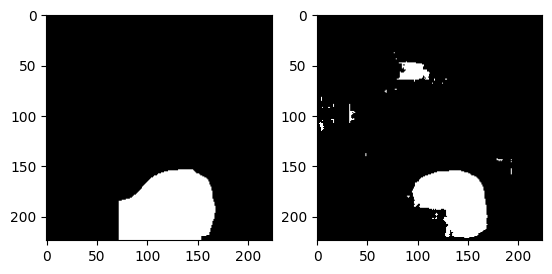

 82%|████████▏ | 82/100 [43:27:16<2:08:40, 428.90s/it]

training started
epoch 83 training total loss: -56.51928800710042 training dice: 0.8539084029446046 training dice loss: 0.14929986468950907 training inverse loss: 5.666858798027039
epoch 83 validation loss: 0.2371864898999532 validation dice: 0.7666485141031444
model saved


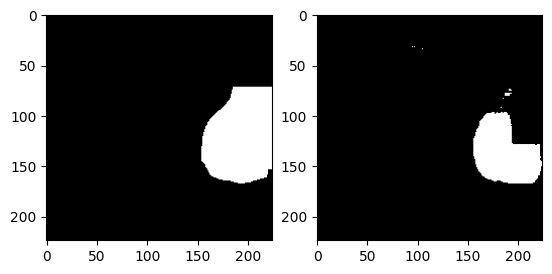

 83%|████████▎ | 83/100 [43:34:06<1:59:57, 423.37s/it]

training started
epoch 84 training total loss: -56.59918398030599 training dice: 0.8487210187539458 training dice loss: 0.1546821482181549 training inverse loss: 5.6753866155942285
epoch 84 validation loss: 0.24091445724169414 validation dice: 0.7633056442687909
model saved


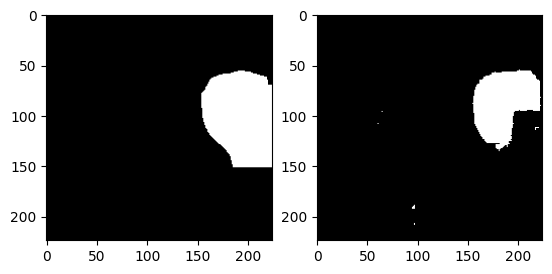

 84%|████████▍ | 84/100 [43:40:52<1:51:31, 418.23s/it]

training started
epoch 85 training total loss: -56.66563057327271 training dice: 0.8497430961091692 training dice loss: 0.15352248406410218 training inverse loss: 5.681915317853292
epoch 85 validation loss: 0.23125886042912802 validation dice: 0.7733495387559136
model saved


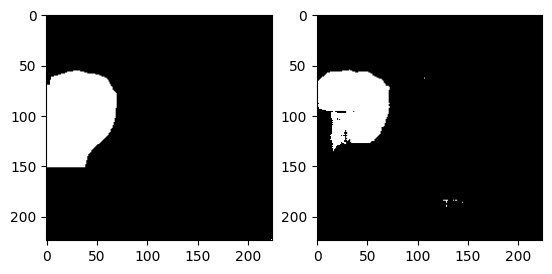

 85%|████████▌ | 85/100 [43:47:43<1:43:56, 415.80s/it]

training started
epoch 86 training total loss: -56.66386251576741 training dice: 0.8525018856103221 training dice loss: 0.15082932543754576 training inverse loss: 5.68146918741862
epoch 86 validation loss: 0.24393234848976136 validation dice: 0.7595399736550947
model saved


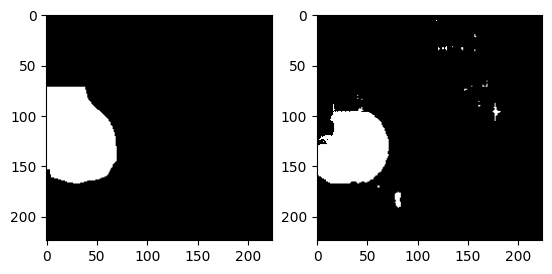

 86%|████████▌ | 86/100 [43:55:32<1:40:46, 431.92s/it]

training started
epoch 87 training total loss: -56.77480103302002 training dice: 0.8542661761616667 training dice loss: 0.14889947994550068 training inverse loss: 5.692370055516561
epoch 87 validation loss: 0.2409457270304362 validation dice: 0.7623951045175393
model saved


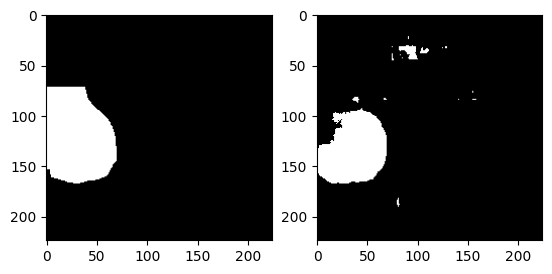

 87%|████████▋ | 87/100 [44:02:56<1:34:22, 435.60s/it]

training started
epoch 88 training total loss: -56.7030567893982 training dice: 0.8522978962461154 training dice loss: 0.1510044170220693 training inverse loss: 5.685406125068664
epoch 88 validation loss: 0.23796469489733377 validation dice: 0.7666109923397502
model saved


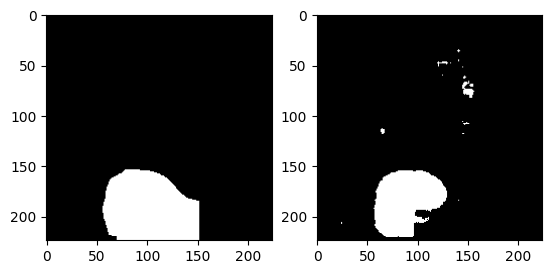

 88%|████████▊ | 88/100 [44:10:26<1:27:59, 439.98s/it]

training started
epoch 89 training total loss: -56.5373829498291 training dice: 0.8543087230593277 training dice loss: 0.14890436871846516 training inverse loss: 5.668628747940064
epoch 89 validation loss: 0.24929099520047507 validation dice: 0.7551589783715705
model saved


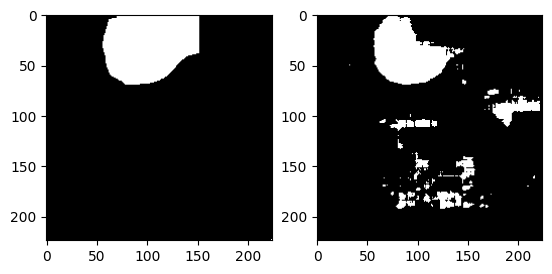

 89%|████████▉ | 89/100 [44:19:03<1:24:51, 462.83s/it]

training started
epoch 90 training total loss: -56.33583667755127 training dice: 0.8501921391934156 training dice loss: 0.15309422135353087 training inverse loss: 5.648893084843953
epoch 90 validation loss: 0.23890887459119162 validation dice: 0.7645494223510225
model saved


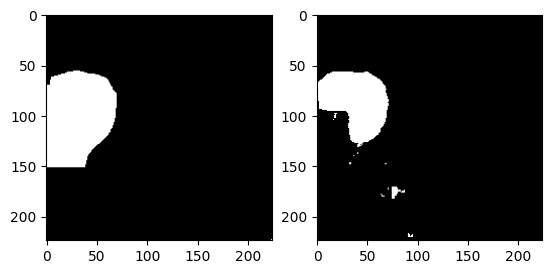

 90%|█████████ | 90/100 [44:26:47<1:17:12, 463.27s/it]

training started
epoch 91 training total loss: -56.403957288106284 training dice: 0.8527666103045146 training dice loss: 0.15049473937352498 training inverse loss: 5.655445211092631
epoch 91 validation loss: 0.2420152254899343 validation dice: 0.7609686888257663
model saved


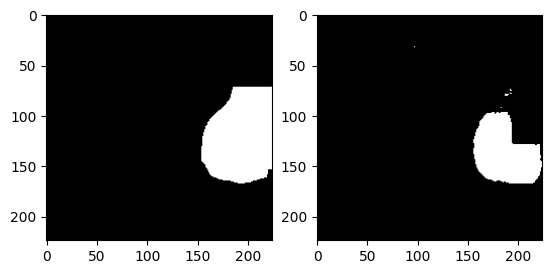

 91%|█████████ | 91/100 [44:31:10<1:00:30, 403.36s/it]

training started
epoch 92 training total loss: -56.76089556630453 training dice: 0.8514492286990086 training dice loss: 0.15193605089187623 training inverse loss: 5.691283173878988
epoch 92 validation loss: 0.24923186818758647 validation dice: 0.7550785900373012
model saved


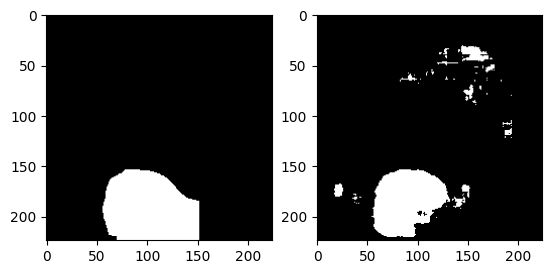

 92%|█████████▏| 92/100 [44:34:06<44:39, 334.88s/it]  

training started
epoch 93 training total loss: -56.664897766113285 training dice: 0.8525010340486964 training dice loss: 0.15060721770922342 training inverse loss: 5.681550503412883
epoch 93 validation loss: 0.24383124748865764 validation dice: 0.76092217395703
model saved


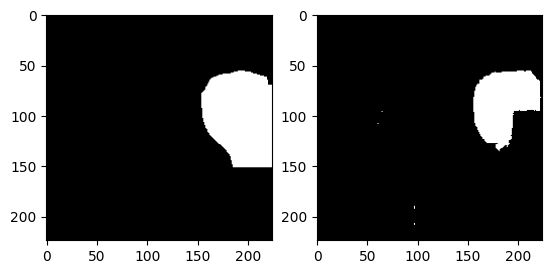

 93%|█████████▎| 93/100 [44:36:12<31:46, 272.42s/it]

training started
epoch 94 training total loss: -56.79037474822998 training dice: 0.8519253903925419 training dice loss: 0.15127425297101338 training inverse loss: 5.694164903958638
epoch 94 validation loss: 0.23456363121668497 validation dice: 0.7698014252570768
model saved


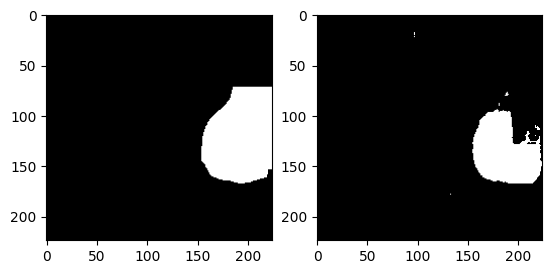

 94%|█████████▍| 94/100 [44:38:18<22:50, 228.42s/it]

training started
epoch 95 training total loss: -56.92390507507324 training dice: 0.850784960427632 training dice loss: 0.1525477409362793 training inverse loss: 5.7076452848116555
epoch 95 validation loss: 0.24069940090179442 validation dice: 0.7630476450027588
model saved


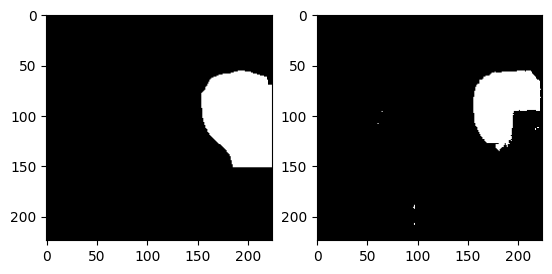

 95%|█████████▌| 95/100 [44:40:22<16:24, 197.00s/it]

training started
epoch 96 training total loss: -56.59865235265096 training dice: 0.854890142912666 training dice loss: 0.14853497529029847 training inverse loss: 5.674718745231629
epoch 96 validation loss: 0.24942542552948 validation dice: 0.7540541349972287
model saved


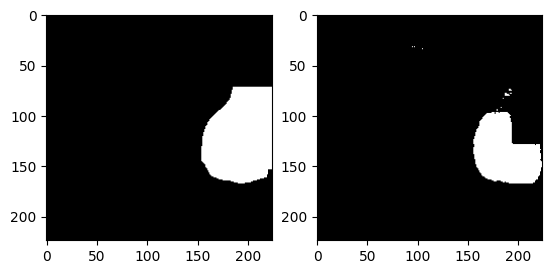

 96%|█████████▌| 96/100 [44:42:26<11:41, 175.28s/it]

training started
epoch 97 training total loss: -56.72958027648926 training dice: 0.8499259439210097 training dice loss: 0.15340083583196004 training inverse loss: 5.68829812669754
epoch 97 validation loss: 0.24464601476987202 validation dice: 0.7593582116812467
model saved


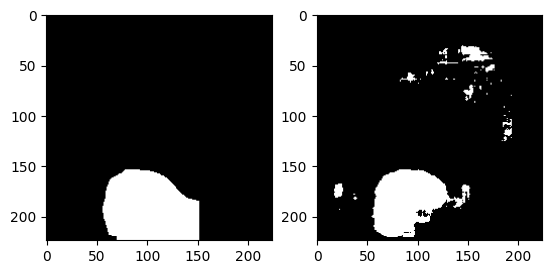

 97%|█████████▋| 97/100 [44:44:32<08:01, 160.51s/it]

training started
epoch 98 training total loss: -56.69076237996419 training dice: 0.8533053350398938 training dice loss: 0.15000824149449665 training inverse loss: 5.68407706785202
epoch 98 validation loss: 0.23932040055592854 validation dice: 0.764000026670595
model saved


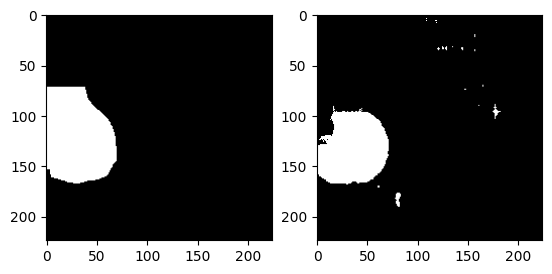

 98%|█████████▊| 98/100 [44:46:36<04:59, 149.57s/it]

training started
epoch 99 training total loss: -56.59562498219808 training dice: 0.8521891352782647 training dice loss: 0.15082535529136656 training inverse loss: 5.674645034154256
epoch 99 validation loss: 0.24348716457684835 validation dice: 0.7605607837376496
model saved


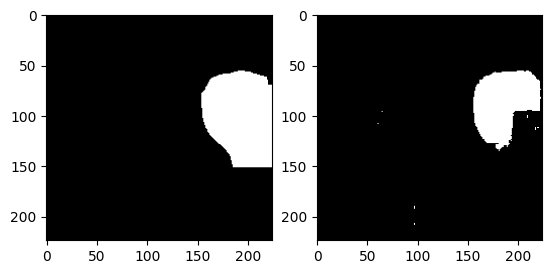

 99%|█████████▉| 99/100 [44:48:38<02:21, 141.31s/it]

training started
epoch 100 training total loss: -56.68312643941243 training dice: 0.8576347663005193 training dice loss: 0.14562699429194131 training inverse loss: 5.682875347137451
epoch 100 validation loss: 0.24550604701042175 validation dice: 0.7590392855741084
model saved


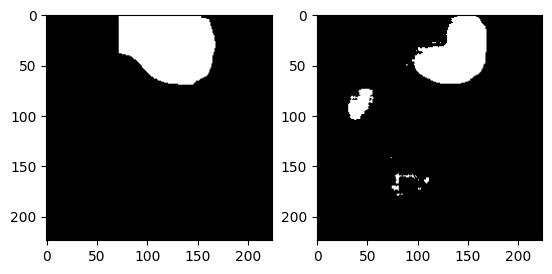

100%|██████████| 100/100 [44:50:42<00:00, 1614.43s/it]


In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm
epochs = 100
train_dice_l = []
train_loss_l = []
train_dice_loss_l = []
train_inverse_loss_l = []
val_dice_l = []
val_loss_l = []


for epoch in tqdm(range(epochs)):
    print("training started")
    model.train()
    epoch_loss = 0
    train_dice_loss = 0
    train_inverse_loss = 0
    train_dice = list()

    for batch in train_loader:
        img, mask = batch["img"].to(device), batch["seg"]
        optimizer.zero_grad()
        pred = model(img).to("cpu")
        loss1 = loss_fn(pred, mask)
        pred = torch.sigmoid(pred)
       
        mask = torch.where(mask > 0.1, torch.tensor(1.0), torch.tensor(0.0))
    
        prob = torch.where(pred > 0.3, torch.tensor(1.0), torch.tensor(0.0))
        out_prob_map = sobel_model(prob)
        y_map = sobel_model(mask)  

        mean_square_inverse_loss = inverse_net(out_prob_map, y_map)

        loss = loss1 - (mean_square_inverse_loss*10)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_dice_loss += loss1.item()
        train_inverse_loss += mean_square_inverse_loss.item()
        
        dice_metric(y_pred = prob, y = mask)
        dice = dice_metric.aggregate().item()
        train_dice.append(dice)
        dice_metric.reset()

    lr_scheduler.step()
    dice_train = np.mean(train_dice)
    train_dice_l.append(dice_train)
    train_loss_l.append(epoch_loss/len(train_loader))
    train_dice_loss_l.append(train_dice_loss/len(train_loader))
    train_inverse_loss_l.append(train_inverse_loss/len(train_loader))

    print(f"epoch {epoch+1} training total loss: {epoch_loss/len(train_loader)} training dice: {dice_train} training dice loss: {train_dice_loss/len(train_loader)} training inverse loss: {train_inverse_loss/len(train_loader)}")
    
    # break
    
    model.eval()
    val_dice = list()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_loader:
            img, mask = val_batch["img"].to(device), val_batch["seg"]
            # mask_onehot = torch.zeros(1,1,mask.shape[1],mask.shape[3])
            mask = torch.where(mask > 0.1, torch.tensor(1.0), torch.tensor(0.0))
            # pred = sliding_window_inference(img, (224, 224), 1, model).to("cpu")
            pred = model(img).to("cpu")
            loss = loss_fn(pred, mask)
            pred = torch.sigmoid(pred)
            prob = torch.where(pred > 0.3, torch.tensor(1.0), torch.tensor(0.0))
            dice_metric(y_pred=prob, y=mask)
            dice = dice_metric.aggregate().item()
            val_dice.append(dice)
            dice_metric.reset()
            val_loss += loss.item()
        dice_val = np.mean(val_dice)
        val_dice_l.append(dice_val)
        val_loss_l.append(val_loss/len(val_loader))
        print(f"epoch {epoch+1} validation loss: {val_loss/len(val_loader)} validation dice: {dice_val}")
        

        if dice_val > 0.70:
            torch.save(model.state_dict(), f"Best_model_{epoch+1}.pth")
            print("model saved")

            
        plt.subplot(1, 2, 1)
        plt.imshow(mask[0,0,:,:], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(prob[0,0,:,:], cmap="gray")
        plt.show()





In [11]:
#Save the train losses and dice coefficient
np.save("train_diceloss.npy", train_dice_loss_l)
np.save("train_loss.npy", train_loss_l)
np.save("train_dice.npy", train_dice_l)
np.save("train_inverse_loss.npy", train_inverse_loss_l)
#save validation losses and dice coefficient
np.save("val_loss.npy", val_loss_l)
np.save("val_dice.npy", val_dice_l)


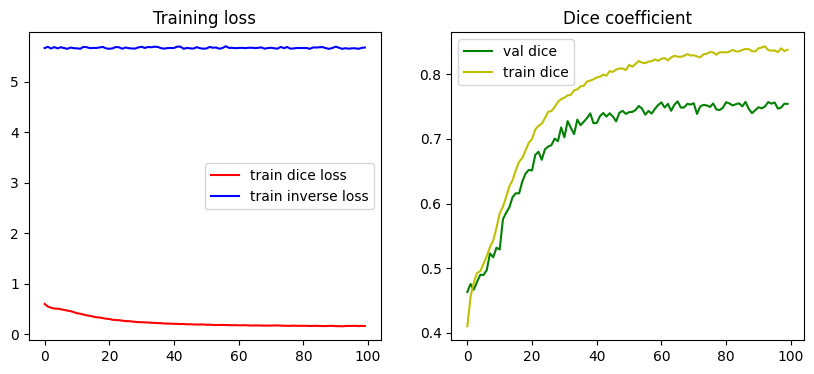

In [26]:
#plot train losses-
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_dice_loss_l, label ="train dice loss", color="r")
# plt.plot(train_loss_l, label ="train total loss", color="b")
plt.plot(train_inverse_loss_l, label ="train inverse loss", color="b")
plt.title("Training loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(val_dice_l, label ="val dice", color="g")
plt.plot(train_dice_l, label ="train dice", color="y")
plt.title("Dice coefficient")
plt.legend()
plt.show()



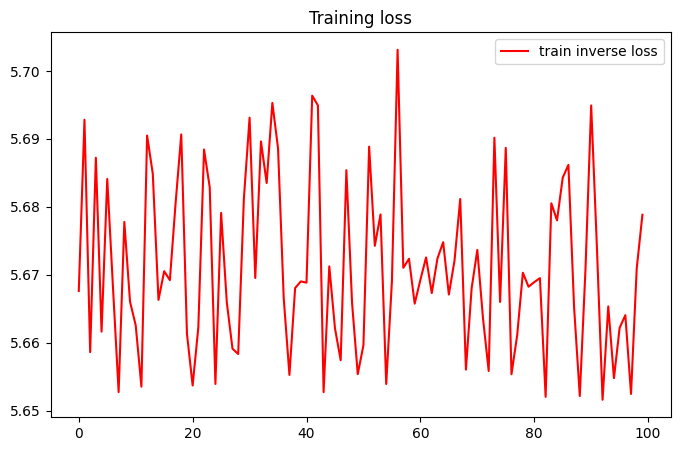

In [24]:
#plot only train inverse loss
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(train_inverse_loss_l, label ="train inverse loss", color="r")
plt.title("Training loss")
plt.legend()
plt.show()

In [14]:
train_dice_loss_l[10]

0.41891403603553773

# Evaluate the model

In [12]:
#load best model 
model.load_state_dict(torch.load("/home/stud1/Kusum/inverseloss/alpha_negative/model4/Best_model_84.pth"))
model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
              (adn): ADN(
                (N): InstanceNorm2d(64, eps=1e-05, m

In [13]:
test_ds = CacheDataset(data=test_data, transform=val_transforms, cache_rate=1.0, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 100/100 [00:00<00:00, 162.38it/s]


unique values in pred tensor([0.0000e+00, 4.3475e-39, 4.4654e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8679999709129333


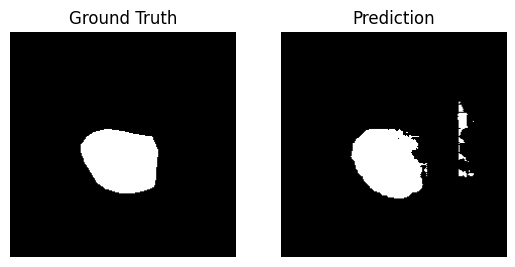

unique values in pred tensor([1.1966e-34, 1.9556e-34, 5.8178e-34,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8837597966194153


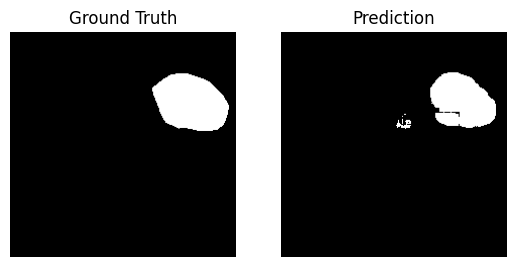

unique values in pred tensor([0.0000e+00, 2.9496e-39, 3.0317e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8501660227775574


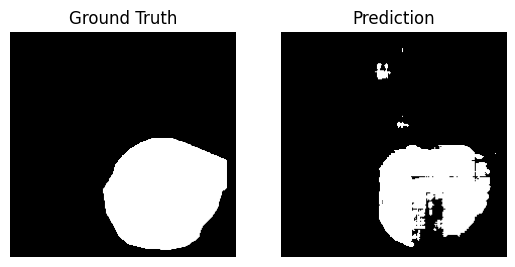

unique values in pred tensor([0.0000e+00, 2.9499e-39, 2.9612e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9697854518890381


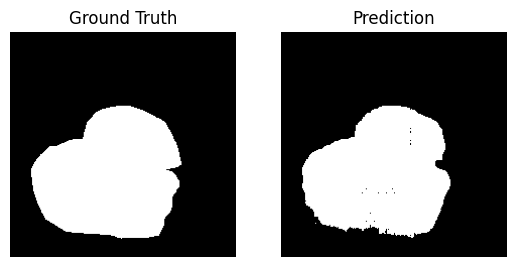

unique values in pred tensor([0.0000e+00, 3.3366e-39, 3.4733e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8467761874198914


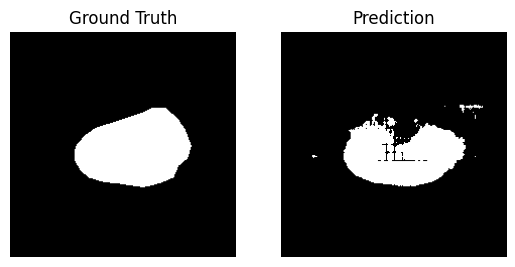

unique values in pred tensor([0.0000e+00, 3.6566e-39, 4.3405e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9273478984832764


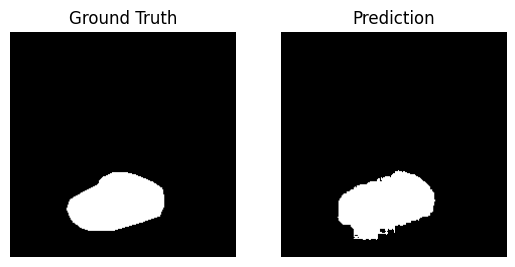

unique values in pred tensor([0.0000e+00, 2.9736e-39, 2.9949e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.4093111753463745


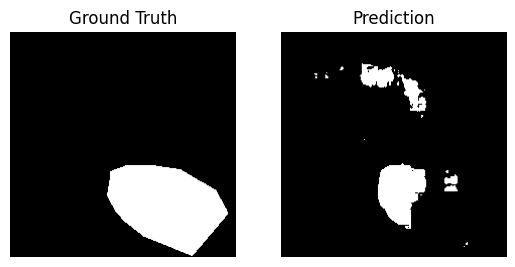

unique values in pred tensor([0.0000e+00, 2.9474e-39, 2.9985e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8706099987030029


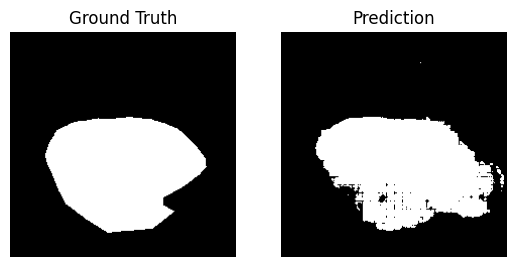

unique values in pred tensor([0.0000e+00, 5.0732e-39, 8.4817e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.735647439956665


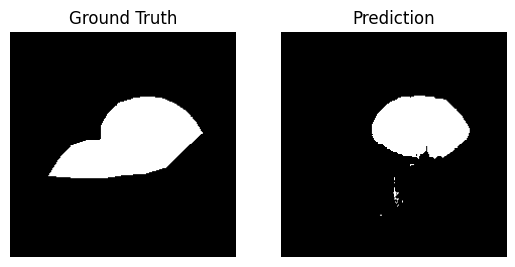

unique values in pred tensor([7.8967e-39, 1.5369e-38, 1.8688e-38,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8741269111633301


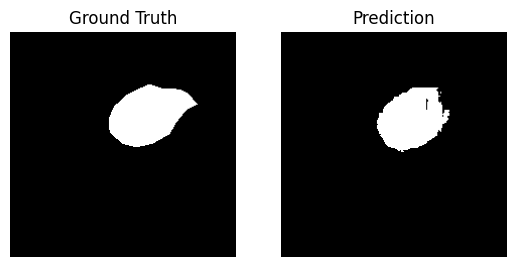

unique values in pred tensor([0.0000e+00, 3.0188e-39, 3.1662e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.1905735433101654


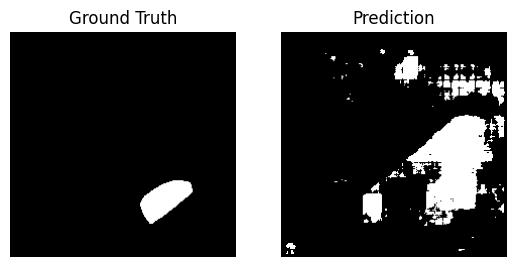

unique values in pred tensor([0.0000e+00, 8.2435e-39, 8.6637e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7101372480392456


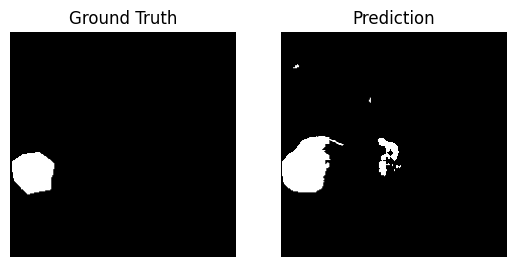

unique values in pred tensor([0.0000e+00, 3.0052e-39, 3.0157e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8352165222167969


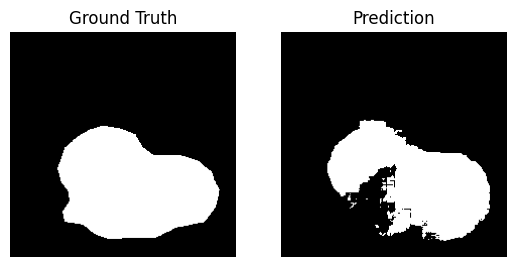

unique values in pred tensor([7.6229e-25, 3.0644e-24, 4.1776e-24,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.924454391002655


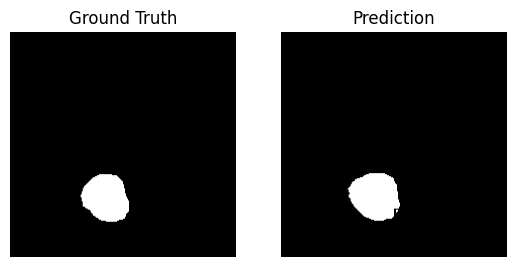

unique values in pred tensor([2.3424e-21, 4.4370e-21, 4.5728e-21,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8756548166275024


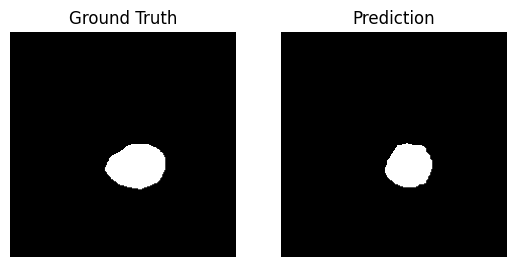

unique values in pred tensor([0.0000e+00, 2.9956e-39, 3.0018e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9410330653190613


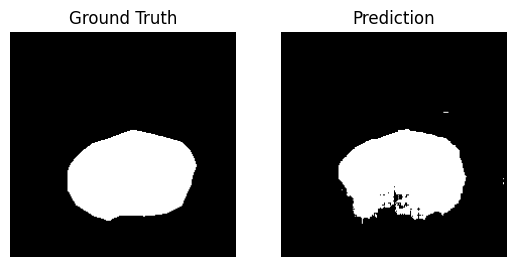

unique values in pred tensor([1.1846e-32, 1.4462e-32, 1.4501e-32,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9282118082046509


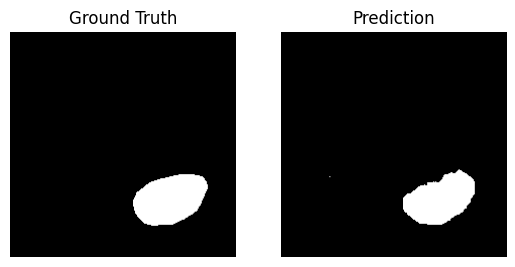

unique values in pred tensor([0.0000e+00, 3.0262e-39, 3.0349e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.923283040523529


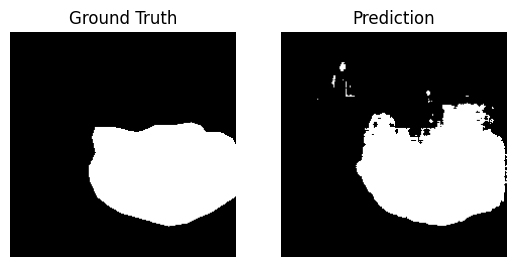

unique values in pred tensor([1.1807e-38, 6.1177e-38, 1.3762e-37,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.5602405071258545


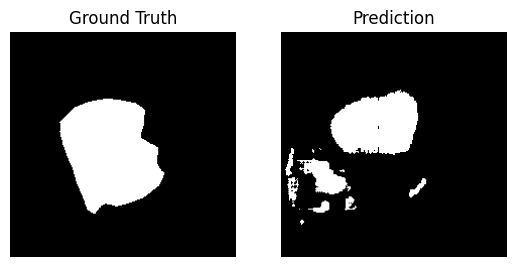

unique values in pred tensor([5.9374e-35, 3.7980e-34, 2.4211e-32,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7643835544586182


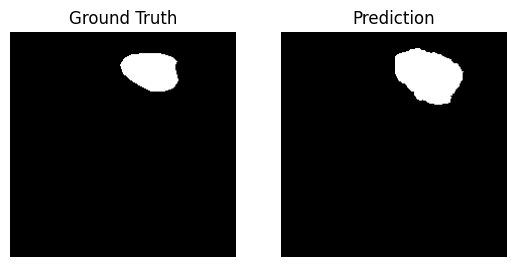

unique values in pred tensor([0.0000e+00, 3.0840e-39, 3.5866e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8286412358283997


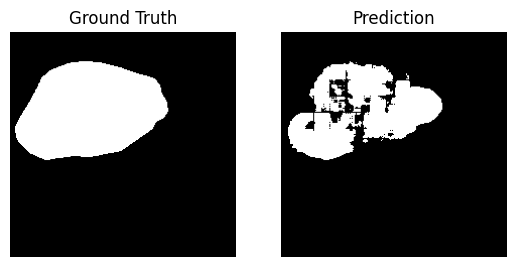

unique values in pred tensor([2.8242e-34, 3.8199e-34, 4.1336e-34,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.6755964756011963


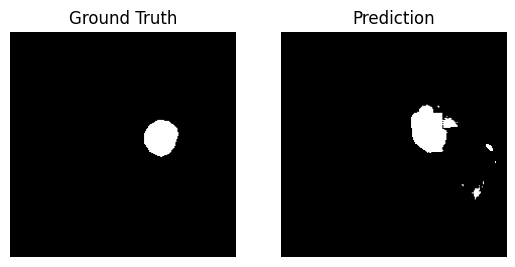

unique values in pred tensor([7.5565e-25, 1.1543e-24, 3.5176e-24,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.920187771320343


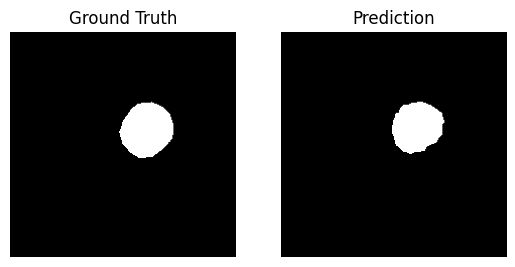

unique values in pred tensor([0.0000e+00, 3.0271e-39, 3.0475e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9447269439697266


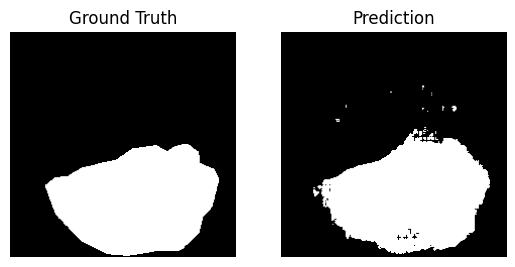

unique values in pred tensor([9.3320e-37, 1.3169e-34, 1.3637e-34,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.889773428440094


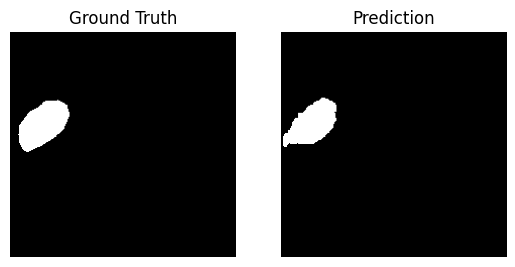

unique values in pred tensor([0.0000e+00, 3.0127e-39, 3.1224e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.5986146330833435


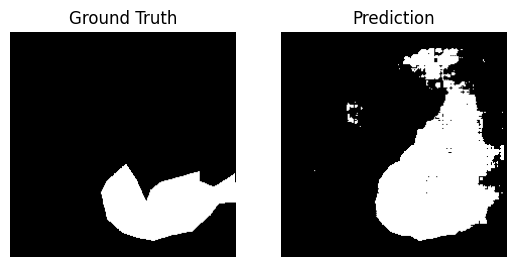

unique values in pred tensor([0.0000e+00, 2.9487e-39, 2.9754e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8673022389411926


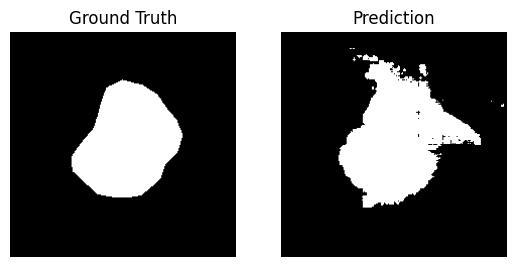

unique values in pred tensor([0.0000e+00, 2.9607e-39, 3.4300e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9738389253616333


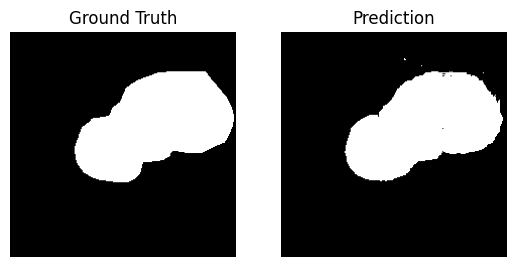

unique values in pred tensor([0.0000e+00, 4.2873e-39, 5.4226e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9344384670257568


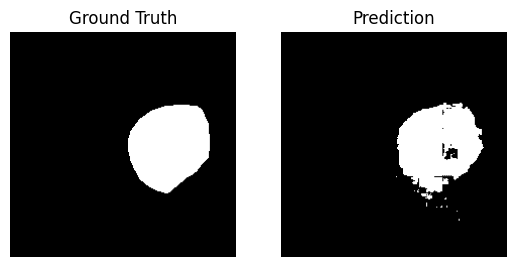

unique values in pred tensor([1.2054e-22, 1.2437e-21, 3.0159e-21,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9302443861961365


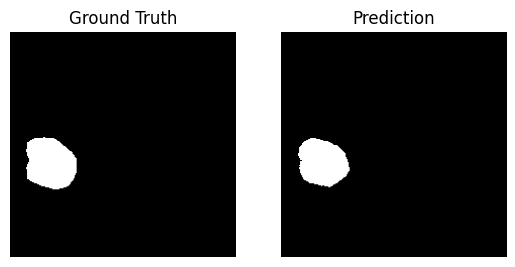

unique values in pred tensor([0.0000e+00, 3.0183e-39, 3.0952e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9575235843658447


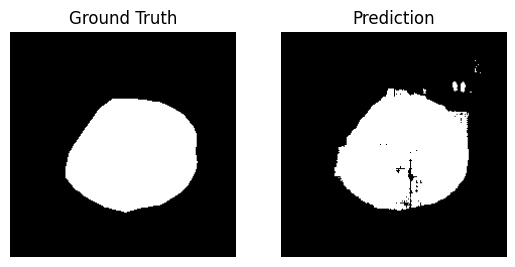

unique values in pred tensor([0.0000e+00, 1.7677e-38, 1.7788e-38,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8229842185974121


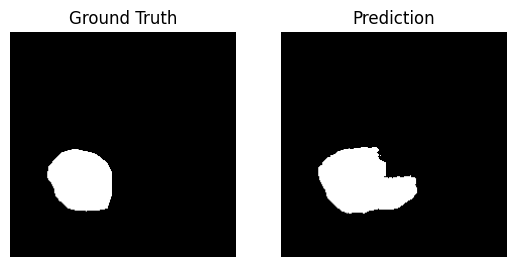

unique values in pred tensor([0.0000e+00, 2.9837e-39, 2.9844e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.029692618176341057


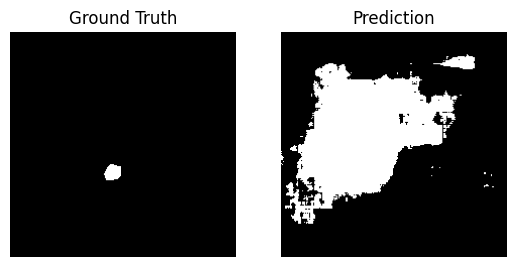

unique values in pred tensor([0.0000e+00, 3.0928e-39, 3.2076e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9604632258415222


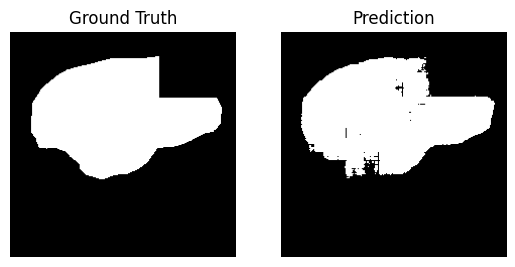

unique values in pred tensor([0.0000e+00, 2.9932e-39, 3.0416e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8711183667182922


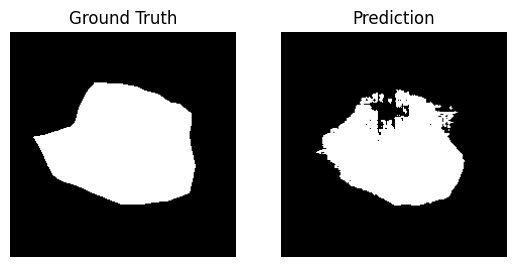

unique values in pred tensor([0.0000e+00, 3.0218e-39, 3.1666e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.532020628452301


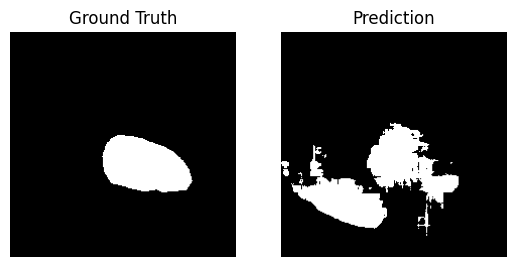

unique values in pred tensor([0.0000e+00, 2.9607e-39, 3.2869e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8605539202690125


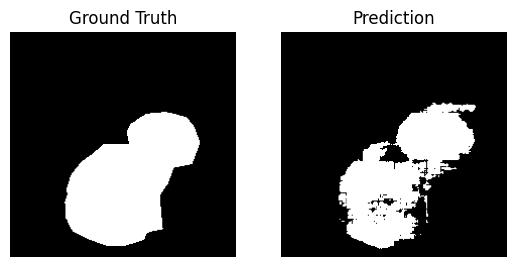

unique values in pred tensor([0.0000e+00, 3.3912e-39, 3.4373e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9479488730430603


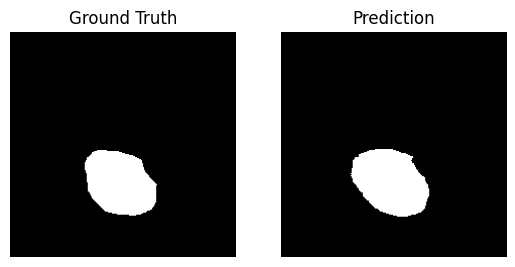

unique values in pred tensor([0.0000e+00, 3.1643e-39, 3.4134e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8704975247383118


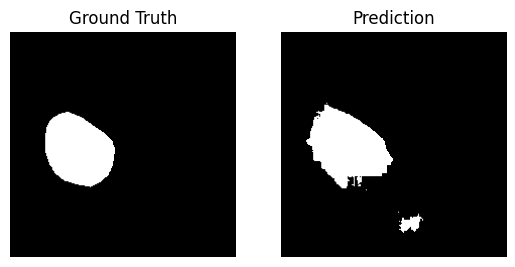

unique values in pred tensor([0.0000e+00, 3.6466e-39, 4.1503e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8483725786209106


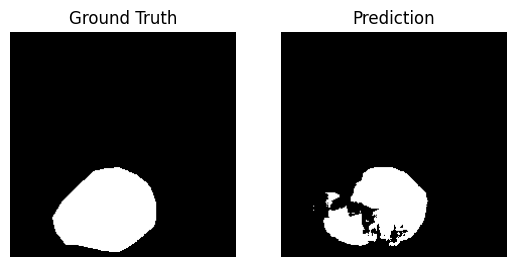

unique values in pred tensor([0.0000e+00, 3.0051e-39, 3.9732e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.6482008695602417


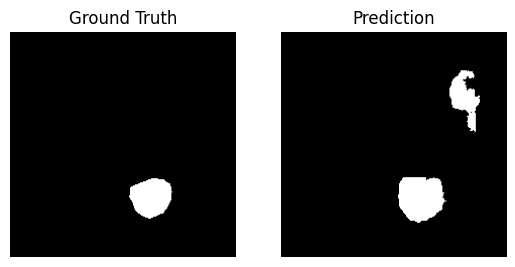

unique values in pred tensor([0.0000e+00, 2.9927e-39, 3.0808e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8339582681655884


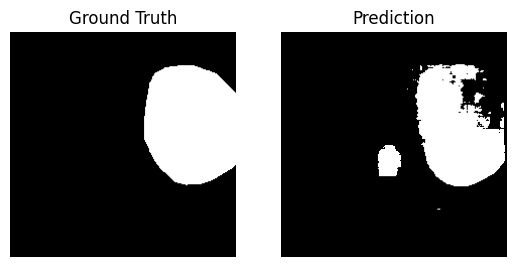

unique values in pred tensor([0.0000e+00, 3.2773e-39, 3.7247e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9012820720672607


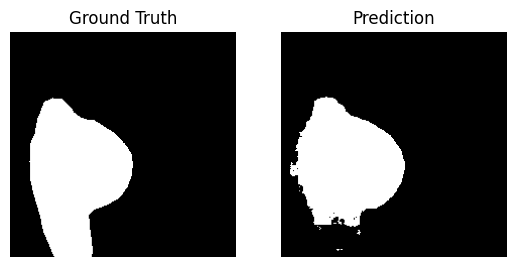

unique values in pred tensor([0.0000e+00, 2.9453e-39, 3.0901e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7848467230796814


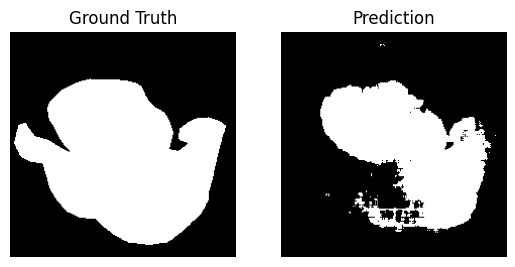

unique values in pred tensor([0.0000e+00, 3.2404e-39, 3.6621e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.957949161529541


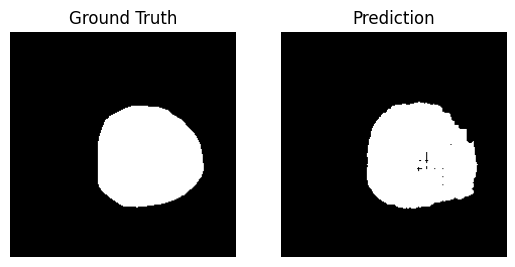

unique values in pred tensor([0.0000e+00, 3.1864e-39, 3.3913e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.3501195013523102


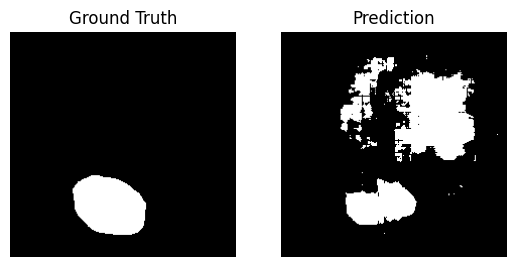

unique values in pred tensor([0.0000e+00, 2.9423e-39, 2.9892e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.6958553791046143


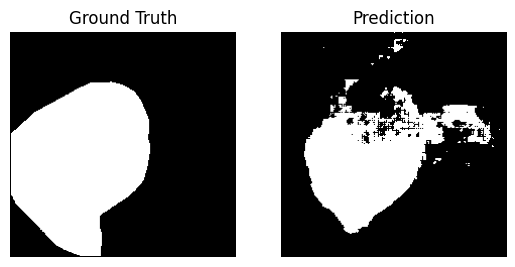

unique values in pred tensor([0.0000e+00, 2.9453e-39, 2.9511e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.3499845564365387


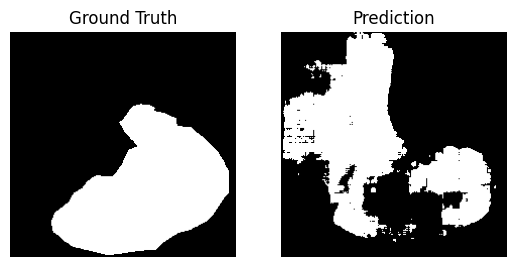

unique values in pred tensor([0.0000e+00, 2.9390e-39, 3.1389e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9340434670448303


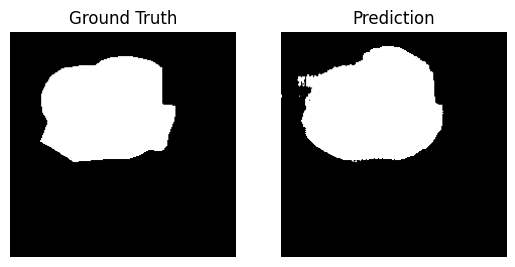

unique values in pred tensor([1.1370e-32, 1.3303e-31, 1.8566e-31,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.3718697726726532


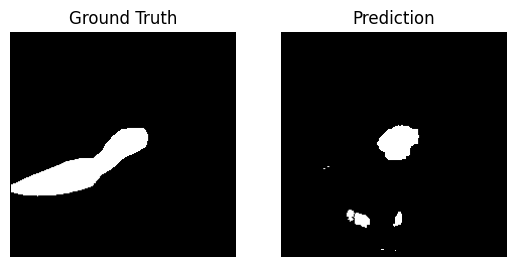

unique values in pred tensor([0.0000e+00, 3.1501e-39, 3.7231e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7863470911979675


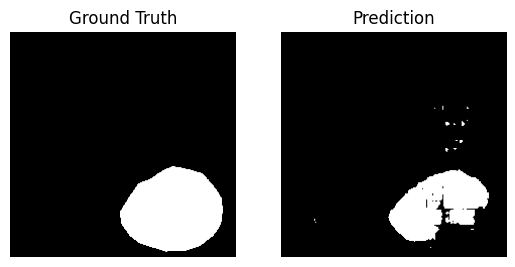

unique values in pred tensor([1.1164e-28, 3.5325e-28, 5.6679e-28,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.75


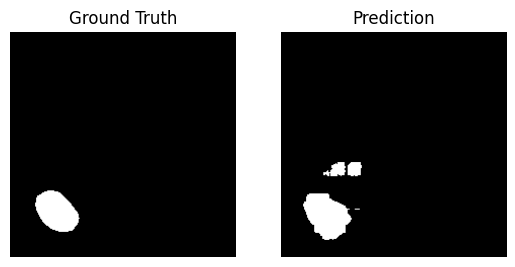

unique values in pred tensor([0.0000e+00, 6.1714e-39, 6.7731e-38,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.3494623601436615


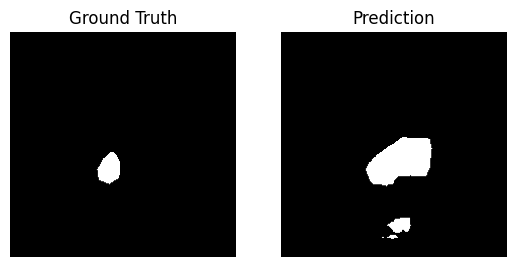

unique values in pred tensor([0.0000e+00, 3.0448e-39, 3.0480e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8911513090133667


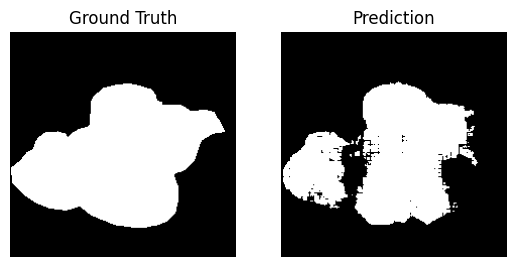

unique values in pred tensor([0.0000e+00, 3.4143e-39, 3.5807e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9617078900337219


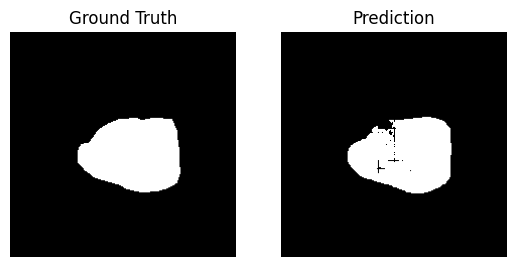

unique values in pred tensor([0.0000e+00, 2.9927e-39, 3.0290e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.3689005970954895


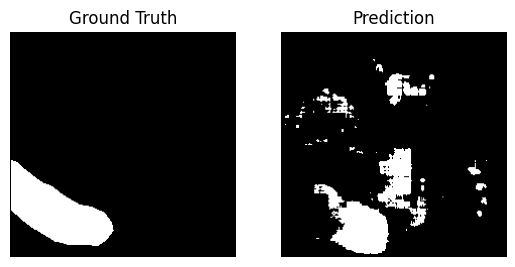

unique values in pred tensor([0.0000e+00, 3.0088e-39, 3.0198e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7180758118629456


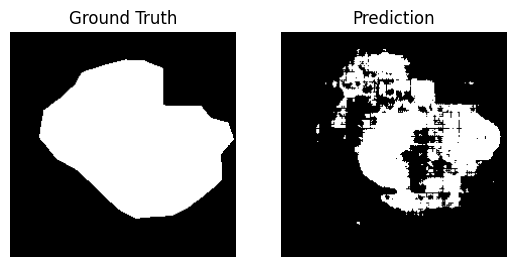

unique values in pred tensor([0.0000e+00, 3.1239e-39, 3.2160e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9300447106361389


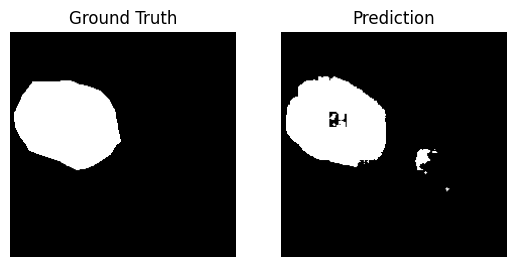

unique values in pred tensor([0.0000e+00, 3.8142e-39, 3.9160e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9610792398452759


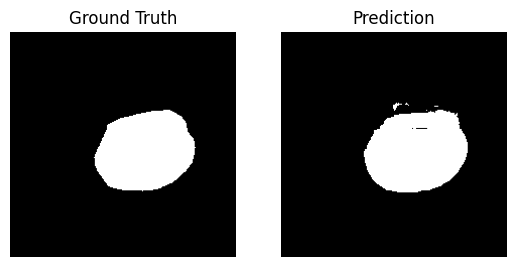

unique values in pred tensor([1.5490e-25, 9.2913e-25, 1.0969e-24,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9376505017280579


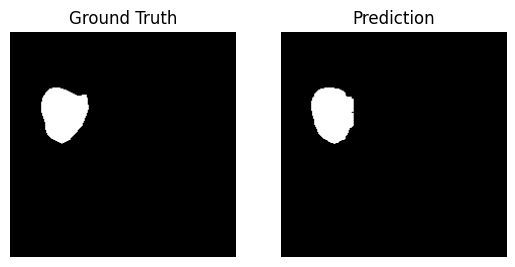

unique values in pred tensor([0.0000e+00, 3.4321e-39, 4.2006e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.5317460298538208


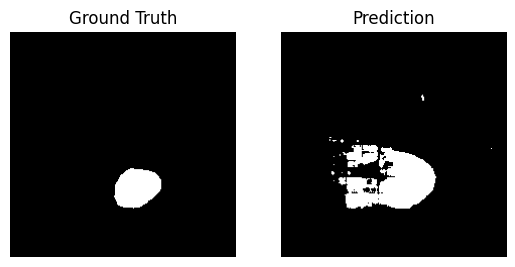

unique values in pred tensor([0.0000e+00, 3.8742e-39, 7.4676e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9050540328025818


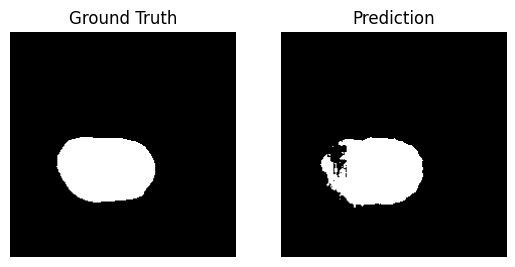

unique values in pred tensor([0.0000e+00, 2.9555e-39, 3.0810e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.02935388684272766


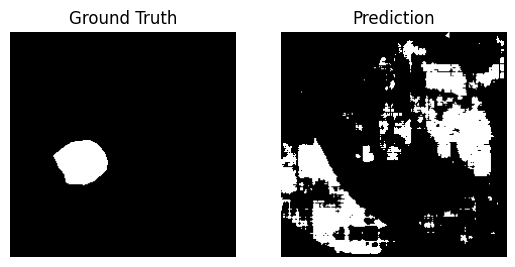

unique values in pred tensor([0.0000e+00, 1.2756e-38, 2.4751e-38,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9803012609481812


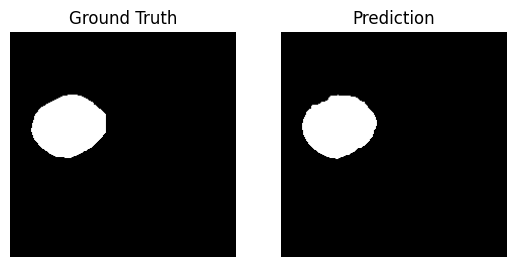

unique values in pred tensor([0.0000e+00, 3.2682e-39, 3.6951e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.854290246963501


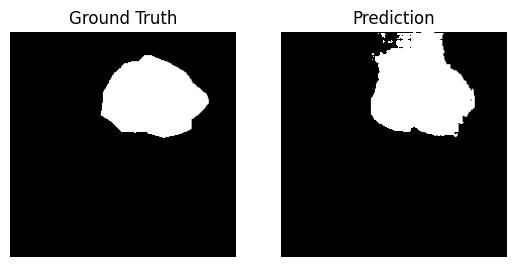

unique values in pred tensor([0.0000e+00, 3.0482e-39, 3.3245e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7387310862541199


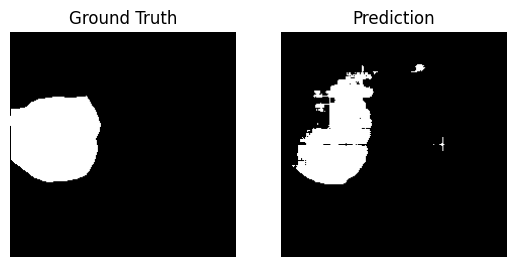

unique values in pred tensor([0.0000e+00, 6.9167e-39, 1.7927e-38,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.6176230907440186


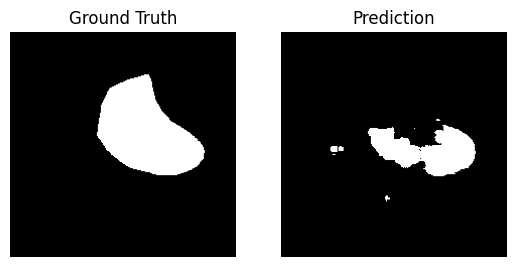

unique values in pred tensor([0.0000e+00, 2.9961e-39, 3.0219e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7876057624816895


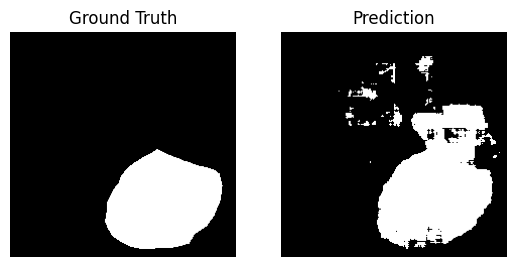

unique values in pred tensor([0.0000e+00, 3.2228e-39, 3.2544e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9217081665992737


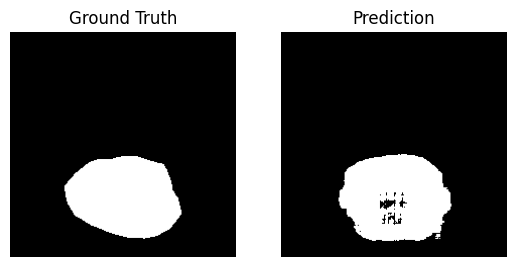

unique values in pred tensor([0.0000e+00, 3.0603e-39, 3.1693e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9354015588760376


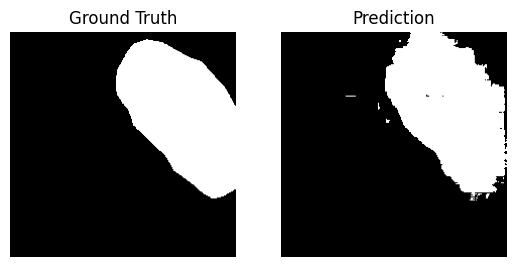

unique values in pred tensor([9.3377e-37, 1.0928e-35, 8.9420e-35,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8473513126373291


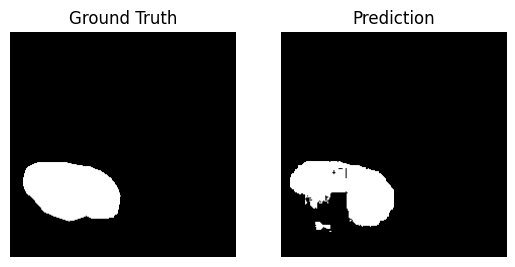

unique values in pred tensor([3.1536e-25, 3.3827e-25, 8.1684e-25,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9077815413475037


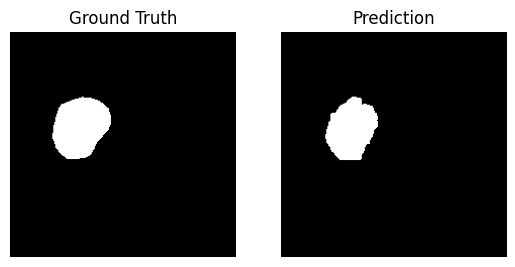

unique values in pred tensor([0.0000e+00, 2.9979e-39, 3.0378e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.6495640277862549


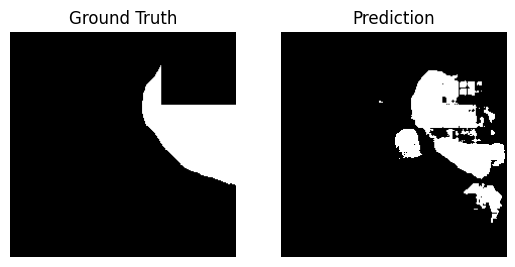

unique values in pred tensor([0.0000e+00, 3.0115e-39, 3.0301e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.9378957748413086


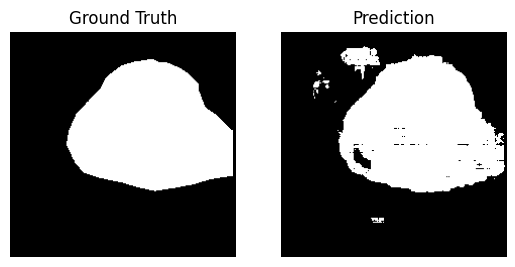

unique values in pred tensor([0.0000e+00, 2.9430e-39, 3.0086e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.43543222546577454


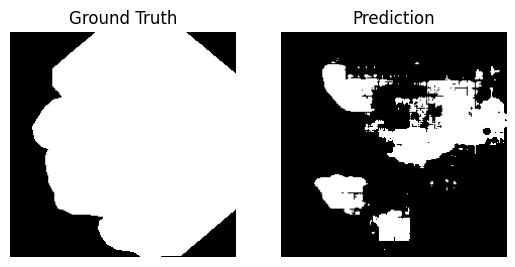

unique values in pred tensor([0.0000e+00, 2.9729e-39, 3.0119e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.20539912581443787


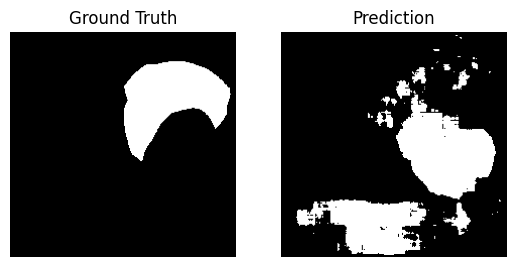

unique values in pred tensor([0.0000e+00, 2.9805e-39, 3.0243e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.5837063789367676


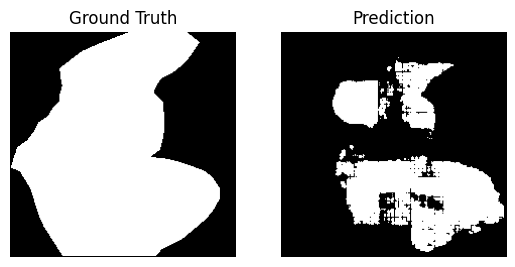

unique values in pred tensor([0.0000e+00, 2.9984e-39, 3.0622e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.2562548816204071


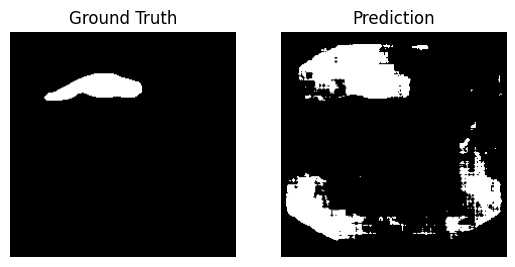

unique values in pred tensor([0.0000e+00, 3.0216e-39, 3.1158e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.6852021813392639


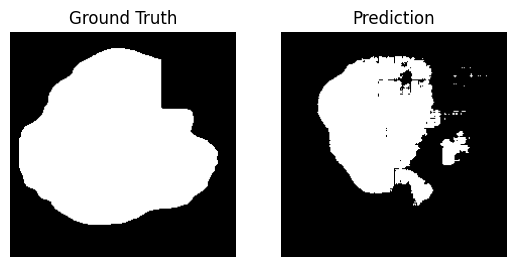

unique values in pred tensor([0.0000e+00, 3.0044e-39, 1.1387e-38,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8650854825973511


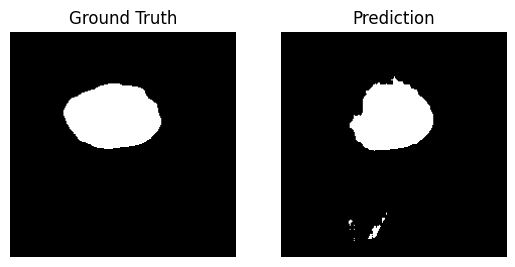

unique values in pred tensor([0.0000e+00, 3.6775e-39, 3.7913e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.44958069920539856


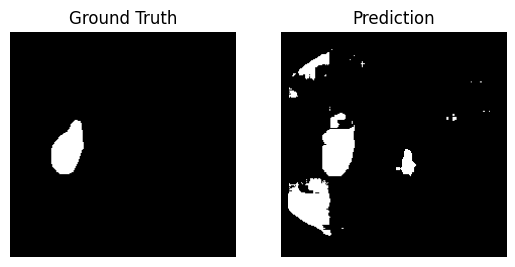

unique values in pred tensor([0.0000e+00, 6.0190e-39, 7.8587e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8488195538520813


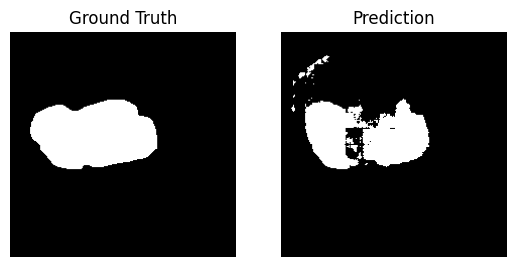

unique values in pred tensor([0.0000e+00, 2.9643e-39, 2.9966e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.5441631078720093


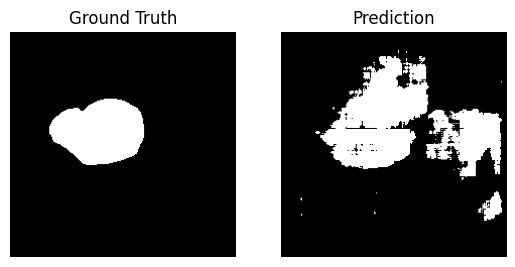

unique values in pred tensor([0.0000e+00, 3.3347e-39, 3.3674e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7763020992279053


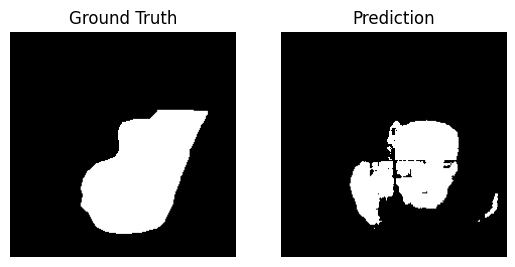

unique values in pred tensor([0.0000e+00, 3.1802e-39, 3.6164e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8149695992469788


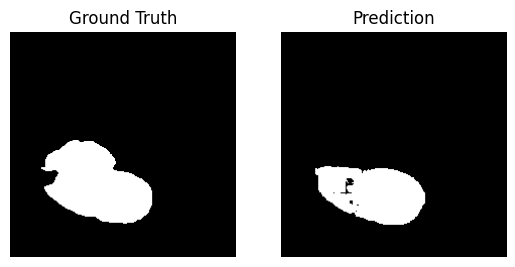

unique values in pred tensor([0.0000e+00, 2.9549e-39, 3.1339e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7848979234695435


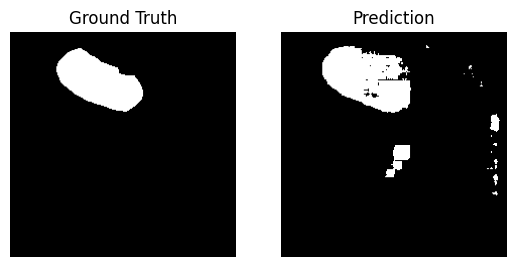

unique values in pred tensor([0.0000e+00, 3.3463e-39, 3.9319e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.5526683926582336


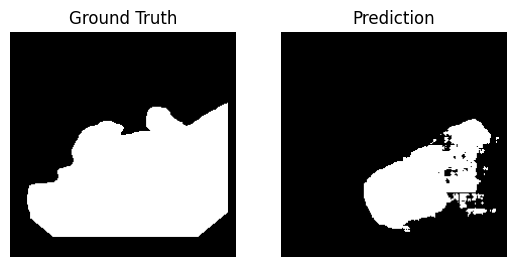

unique values in pred tensor([2.6243e-32, 3.1074e-32, 3.9770e-32,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7088607549667358


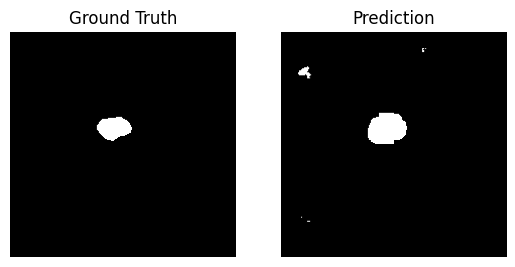

unique values in pred tensor([5.2046e-33, 8.3333e-33, 2.2383e-32,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.8774860501289368


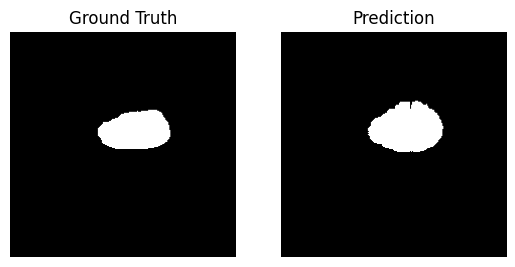

unique values in pred tensor([0.0000e+00, 4.2385e-39, 5.2365e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7200303077697754


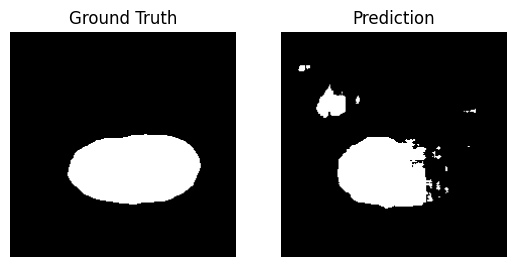

unique values in pred tensor([0.0000e+00, 2.9539e-39, 3.7142e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.746712863445282


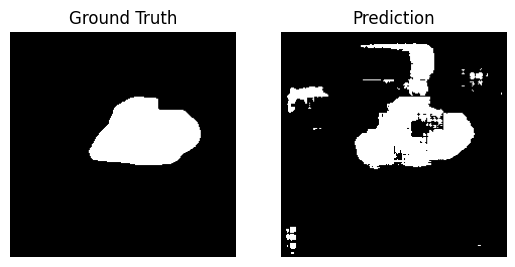

unique values in pred tensor([0.0000e+00, 1.4442e-38, 1.7310e-38,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.7703921794891357


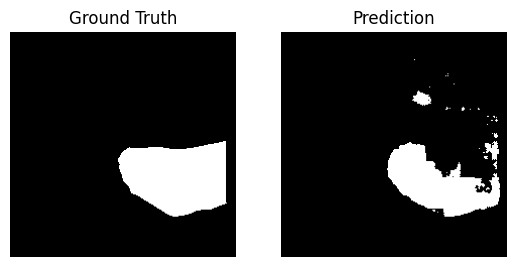

unique values in pred tensor([0.0000e+00, 5.6414e-39, 9.5512e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.18282869458198547


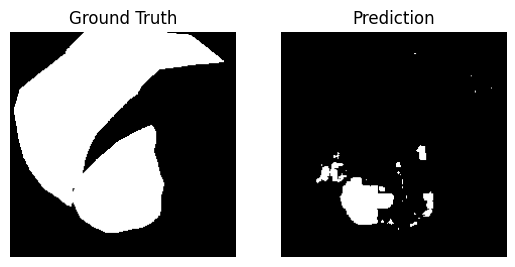

unique values in pred tensor([0.0000e+00, 2.9912e-39, 3.4174e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.707683801651001


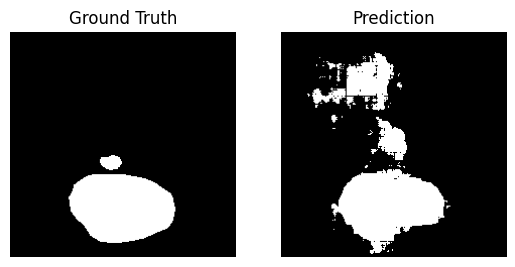

unique values in pred tensor([0.0000e+00, 2.9460e-39, 3.0007e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.15592527389526367


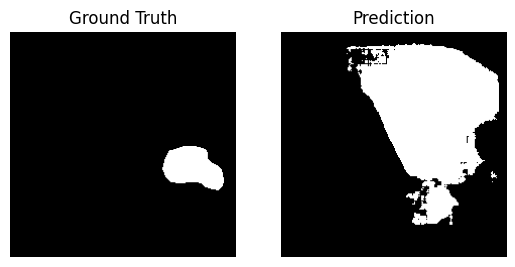

unique values in pred tensor([0.0000e+00, 3.0811e-39, 3.0866e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.4965232014656067


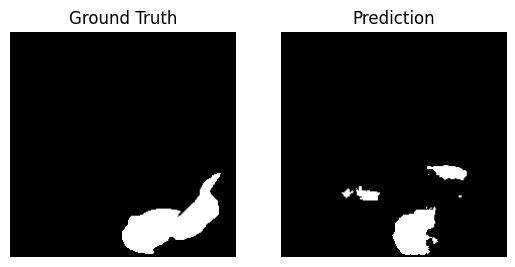

unique values in pred tensor([0.0000e+00, 3.0968e-39, 3.1023e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.14235904812812805


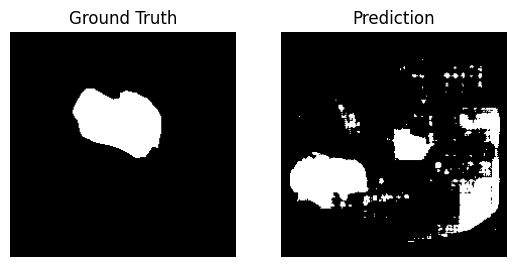

unique values in pred tensor([0.0000e+00, 2.9925e-39, 3.2843e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.5760560035705566


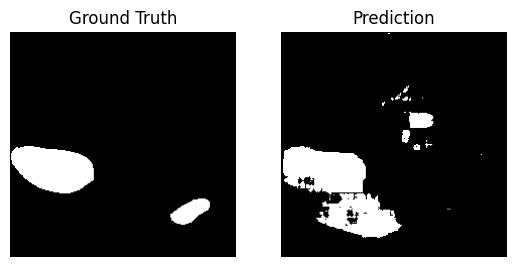

unique values in pred tensor([2.8759e-29, 1.2233e-28, 2.3470e-28,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.22187428176403046


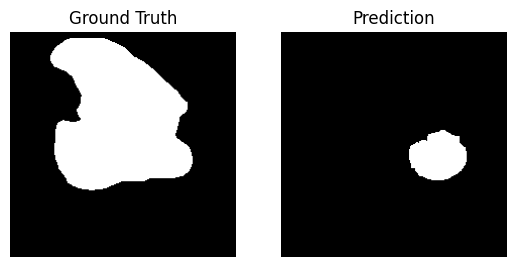

unique values in pred tensor([0.0000e+00, 3.1483e-39, 5.5794e-39,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], grad_fn=<Unique2Backward0>)
dice score on test data 0.31172701716423035


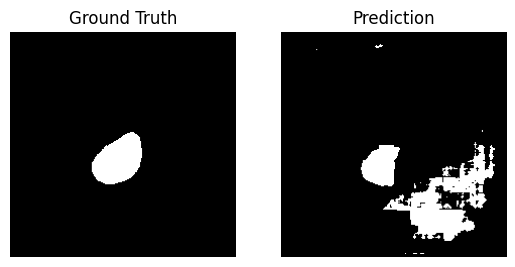

mean of the dice score on test data 0.7170113758556544


In [14]:
import matplotlib.pyplot as plt

dice_val = []
for batch in test_loader:
    img, mask = batch["img"].to(device), batch["seg"]
    # pred = sliding_window_inference(img, (224, 224), 2, model).to("cpu")
    pred = model(img).to("cpu")
    pred = torch.sigmoid(pred)
    print("unique values in pred", torch.unique(pred))
    mask = torch.where(mask > 0.8, torch.tensor(1.0), torch.tensor(0.0))
    prob = torch.where(pred > 0.8, torch.tensor(1.0), torch.tensor(0.0))
    dice_metric(y_pred=prob, y=mask)
    dice = dice_metric.aggregate().item()
    dice_metric.reset()
    dice_val.append(dice)
    print("dice score on test data", dice)
    plt.subplot(1, 2, 1)
    plt.imshow(mask[0,0,:,:], cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(prob[0,0,:,:], cmap="gray")
    plt.title("Prediction")
    plt.axis("off")
    plt.show()
print("mean of the dice score on test data", np.mean(dice_val))
np.save("test_dice.npy", dice_val)